<a href="https://colab.research.google.com/github/monarkparekh/MAE-598__Design-Optimization/blob/Project-1/MAE_598__Design_Optimization_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b><h1>MAE 598 Design Optimization: 
Project 1</h1></b>

<h2>Name: Monark Parekh <br>
ASU ID: 1222179426</h2>


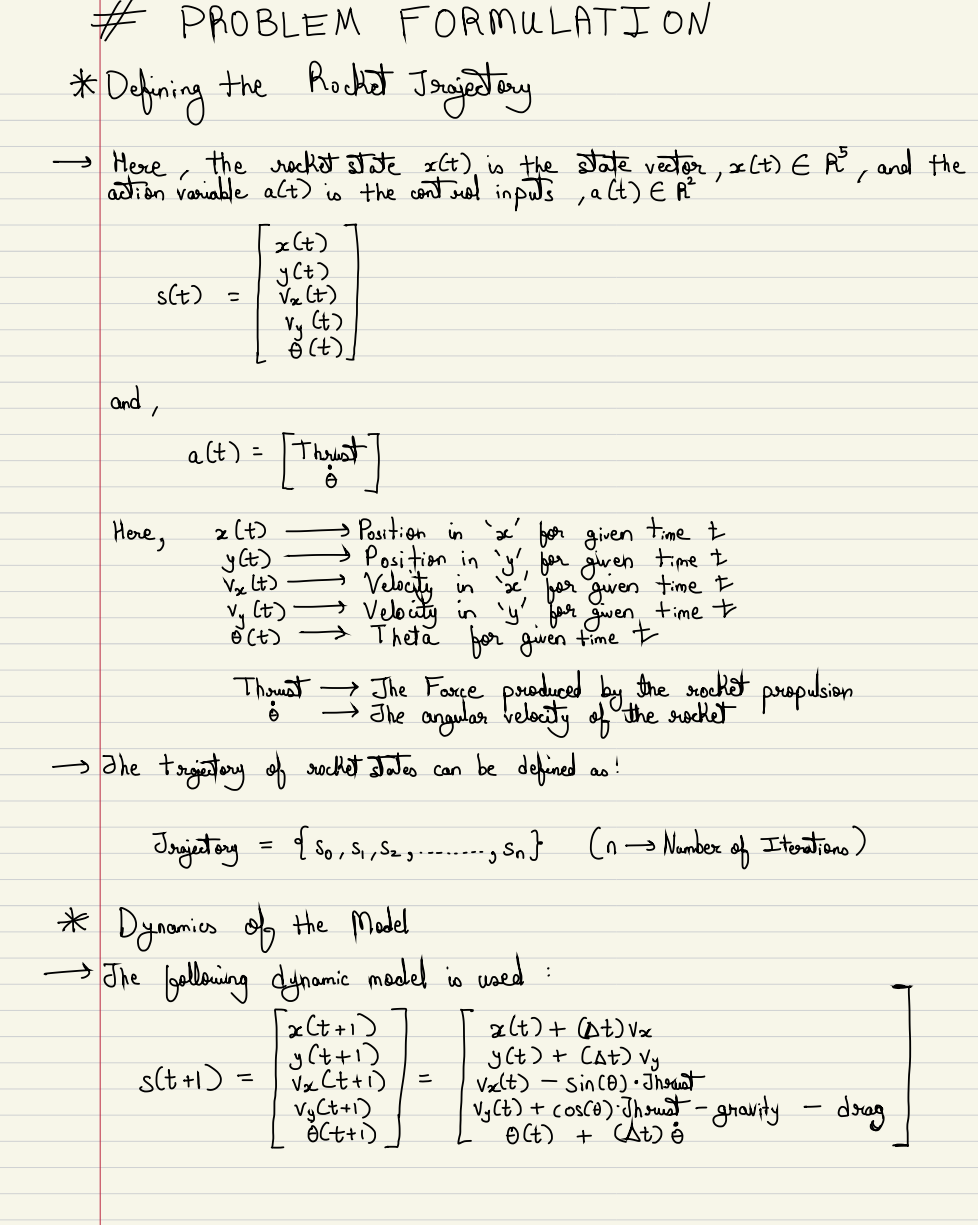

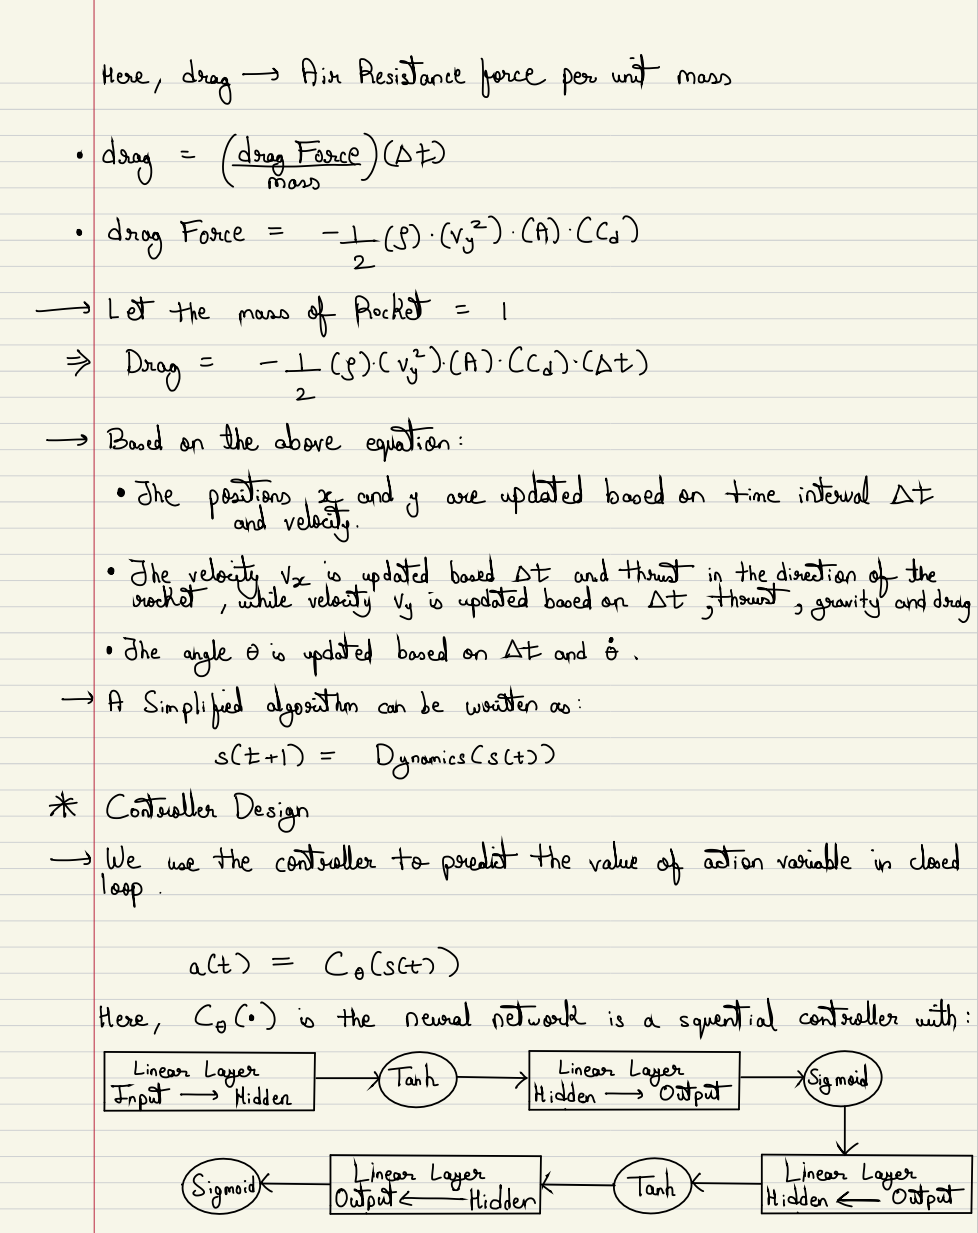

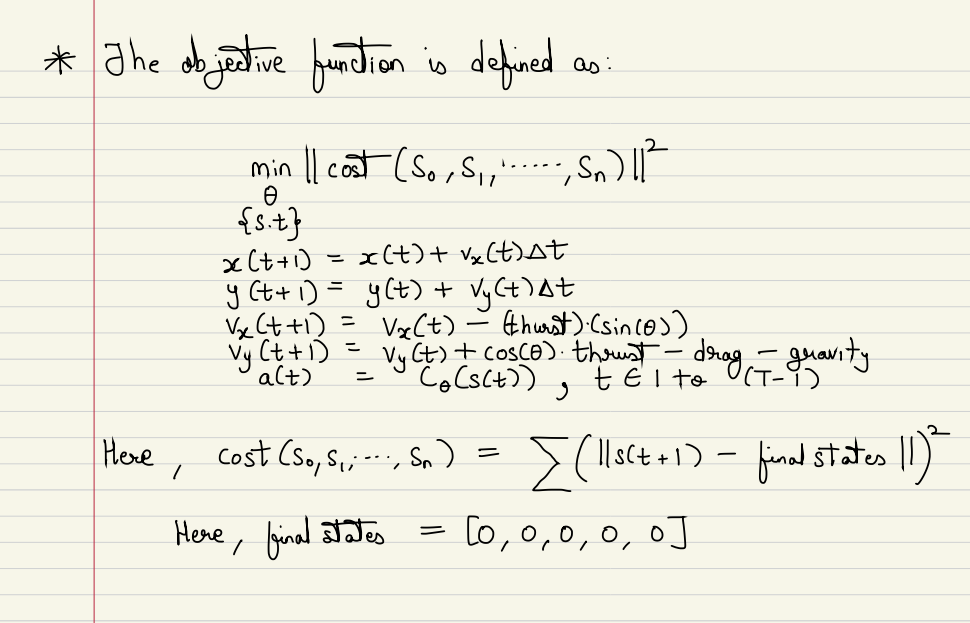

**Importing the necessary Libraries**

In [ ]:
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

**Defining the Envrionment Paramerters**

In [ ]:
'''
1) The FRAME_TIME depicts the time interval for calculations
2) GRAVITY_ACCEL_X is the gravitational accelaration in x direction 
3) GRAVITY_ACCEL_Y is the gravitational accelaration in y direction 
4) BOOST_ACCEL is the thrust constant 
5) Cd is the Coefficient of Drag
6) rho is the desnsity of air 
7) Area of Cros-section of the Rocket
'''
FRAME_TIME = 0.1  
GRAVITY_ACCEL_X = 0.0
GRAVITY_ACCEL_Y = 0.12
BOOST_ACCEL = 0.15 
Cd = 1
rho = 0.08
A = 0.1 

**Defining the System Dynamics**

In [ ]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        Here the system state is defined by 5 parameters: 
          1) "x"     -----> The displacement of the rocket in x-direction
          2) "y"     -----> The displacement of the rocket in y-direction
          3) "x_dot" -----> The velocity of the rocket in x-direction
          4) "y_dot" -----> The velocity of the rocket in y-direction
          5) "theta" -----> The angle of rotation of the rocket about its center of mass

        The array "state" stores the five system states defined above.
        state[0] = x
        state[1] = y
        state[2] = x_dot
        state[3] = y_dot
        state[4] = theta

        Whereas, the control actions comprise of:
          1) "thrust" ----> The Force produced by the rocket propulsion
          2) "theta_dot" -> The angular velocity of the rocket about its center of mass

        The array "action" stores the three control actions defined above.
        action[0] = thrust 
        action[1] = theta_dot
        """

        # Here "-GRAVITY_ACCEL_X * FRAME_TIME" depicts the effect of gravity in x direction, and
        # "-GRAVITY_ACCEL_Y * FRAME_TIME" depicts the effect of gravity in y direction.
        delta_state_gravity = torch.tensor([0., 0.,-GRAVITY_ACCEL_X * FRAME_TIME, -GRAVITY_ACCEL_Y * FRAME_TIME, 0.])

        # Calculating the Thrust for the given state
        state_tensor = torch.zeros((1, 5))
        state_tensor[0, 2] = torch.cos(state[0, 4])
        state_tensor[0, 3] = torch.sin(state[0, 4])
    
        delta_state = BOOST_ACCEL * FRAME_TIME * torch.mul(state_tensor, action[0, 0].reshape(-1, 1))

        # Calculating the Theta for the given state and action 
        delta_state_theta = FRAME_TIME * torch.mul(torch.tensor([0., 0., 0., 0, 1.]),(action[0, 1]).reshape(-1, 1))

        # Calculating the Drag for the given state and action  
        Vy = torch.matmul(state,torch.tensor([0., 0., 0., 1., 0.]))
        drag_y = -rho*Vy*Vy*A*Cd

        state = state + delta_state  + delta_state_gravity + delta_state_theta - drag_y

        # Updating the state based on the Frame Time
        step_mat = torch.tensor([[1., 0.,FRAME_TIME, 0., 0.],
                                 [0., 1., 0., FRAME_TIME, 0.],
                                 [0., 0., 1.,0., 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])

        state = torch.matmul(step_mat, state.T)     
        return state.T

**Defining the System Controller**

In [ ]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input:  Number of system states
        dim_output: Number of actions
        dim_hidden: Number of hidden layers
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid(),
            nn.Linear(dim_output,  dim_hidden),
            nn.Tanh(),
            nn.Linear( dim_hidden, dim_output),
            nn.Sigmoid())
    def forward(self, state):
        # Bounding the "theta_dot" in the range of -1 to 1
        action = self.network(state)
        action = (2*action - torch.tensor([0., 1])) 
        return action

**Defining the Simulation Module**

In [ ]:
class Simulation(nn.Module):
    """
    The Following Module is resposible for bringing togethere all the above modules and
    determining the loss based on state variables
    """
    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[-2.,2.,0.,0.,0.]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
    
        return torch.mean(state ** 2)

**Defining the Optimizer**

In [ ]:
class Optimize:    
    def __init__(self, simulation):
        self.simulation = simulation                            # Defining the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.007) # Defining the opmization algorithm
        self.loss_list = []

    # Defining the loss calculation method for objective function
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # Calculating the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # Calculating the Gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Defining the training method for the model
    def train(self, epochs):
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() 
            self.loss_list.append(loss) 
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            l[epoch]=loss
            self.visualize()
            
        plt.plot(list(range(epochs)), l)
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()

        
        
    # Plotting the states
    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        vx = data[:, 2]
        vy = data[:, 3]
        theta = data[:, 4]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        thrust = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1, 6, tight_layout = 1, figsize = (25, 5))

        ax[0].plot(x, y, c = 'b')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Y")
        ax[0].set(title=f'Position Plot (y vs x) at {self.epoch + 1} iteration')

        ax[1].plot(frame, vx, c = 'c', label = "Velocity in x")
        ax[1].plot(frame, vy, c = 'r', label = "Velocity in y")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Velocity in (m/s)")
        ax[1].legend(frameon=0)
        ax[1].set(title =f'Change in Velocity for {self.epoch + 1} iteration')

        ax[2].plot(frame, theta, c = 'g', label = "theta")
        ax[2].set_xlabel("Time interval")
        ax[2].set_ylabel("Theta in (rad)")
        ax[2].legend(frameon=0)
        ax[2].set(title=f'Change in Theta for {self.epoch + 1} iteration')

        ax[3].plot(frame, thrust, c = 'k', label = "thrust")
        ax[3].set_xlabel("Time interval")
        ax[3].set_ylabel("Thrust in (N)")
        ax[3].legend(frameon=0)
        ax[3].set(title=f'Change in Thrust for {self.epoch + 1} iteration')

        ax[4].plot(x, vx, c = 'm', label = "Velocity in x")
        ax[4].set_xlabel("Position in x")
        ax[4].set_ylabel("Velocity in x in (m/s)")
        ax[4].legend(frameon=0)
        ax[4].set(title =f'Velocity in x w.r.t x')

        ax[5].plot(y, vy, c = 'm', label = "Velocity in y")
        ax[5].set_xlabel("Position in y")
        ax[5].set_ylabel("Velocity in y in (m/s)")
        ax[5].legend(frameon=0)
        ax[5].set(title =f'Velocity in y w.r.t y')

        plt.show()

[1] loss: 2.859


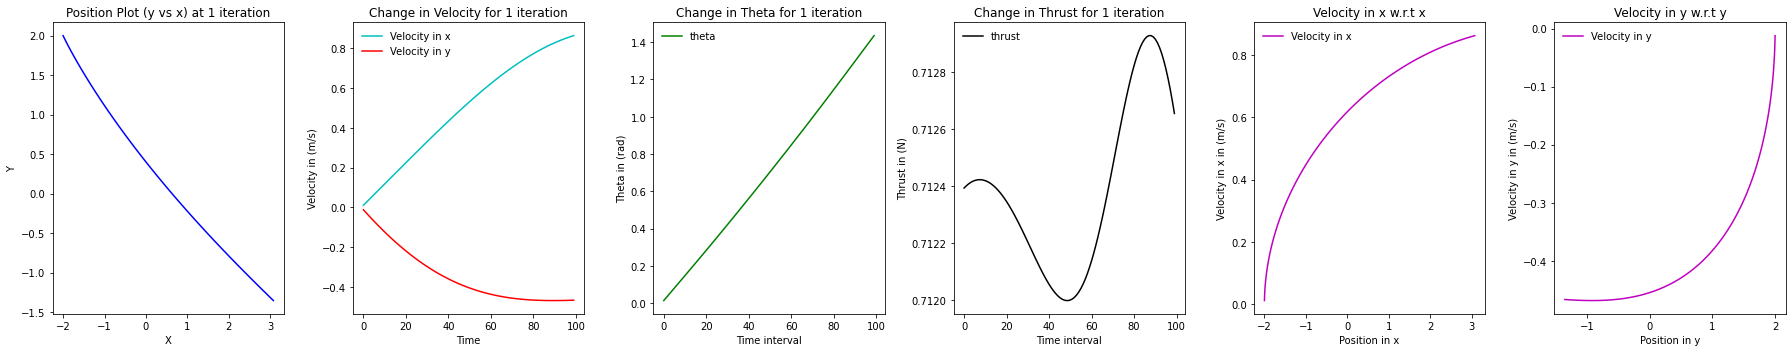

[2] loss: 2.412


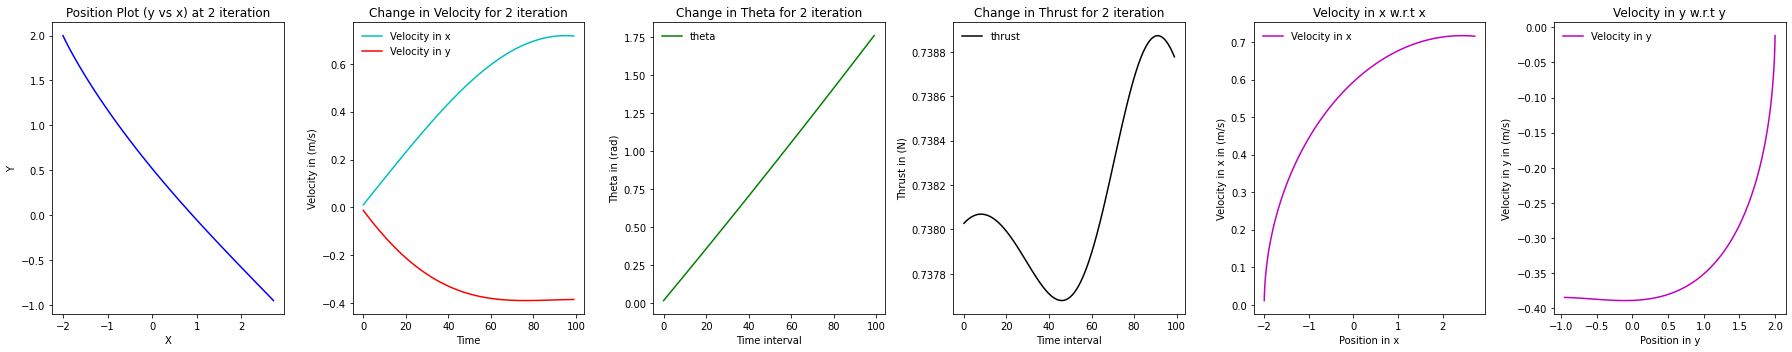

[3] loss: 2.160


[4] loss: 2.006


[5] loss: 1.902


[6] loss: 1.821


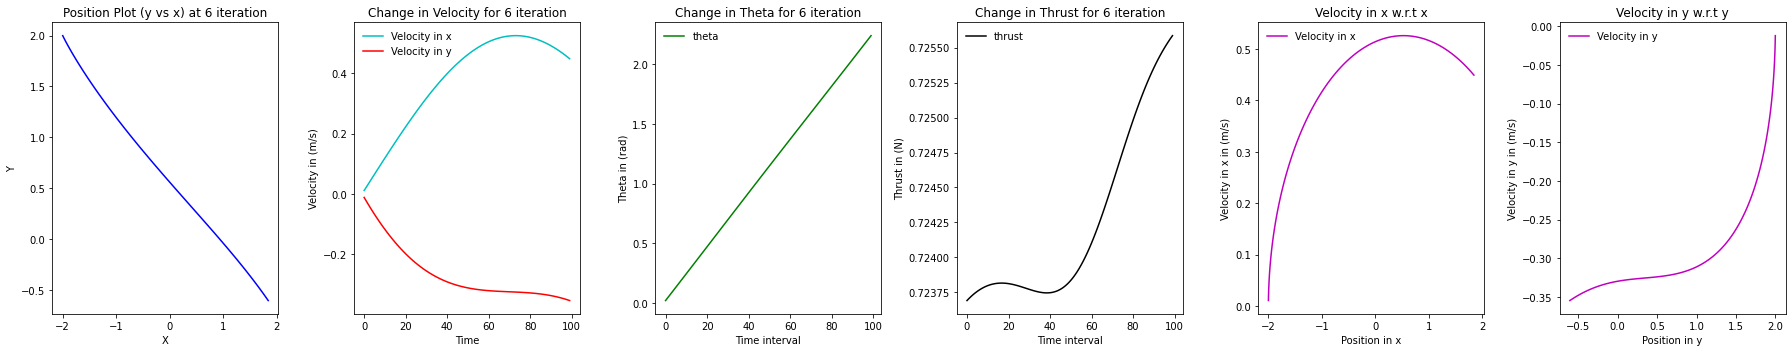

[7] loss: 1.750


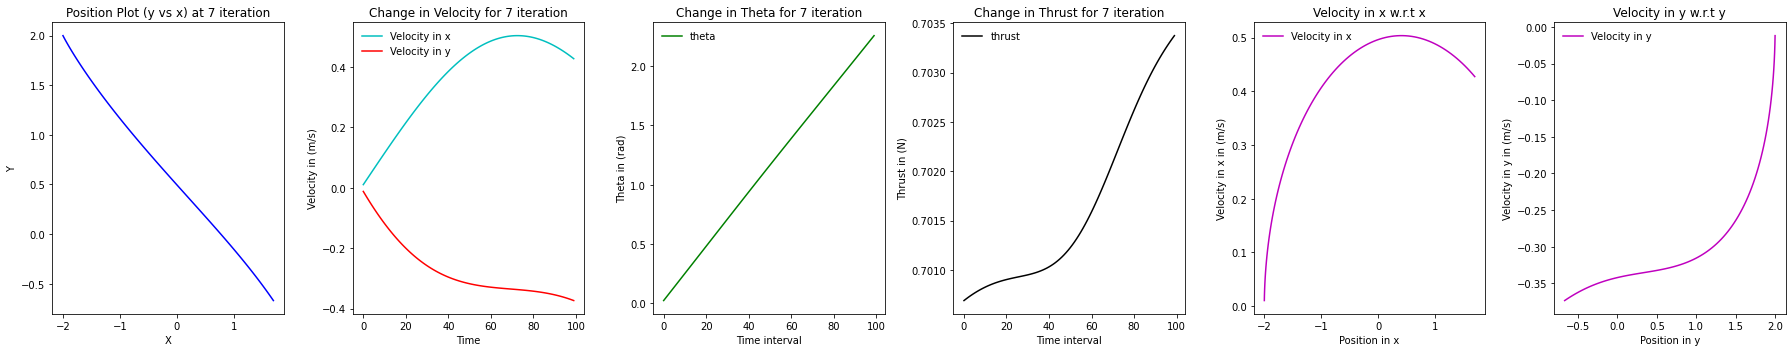

[8] loss: 1.686


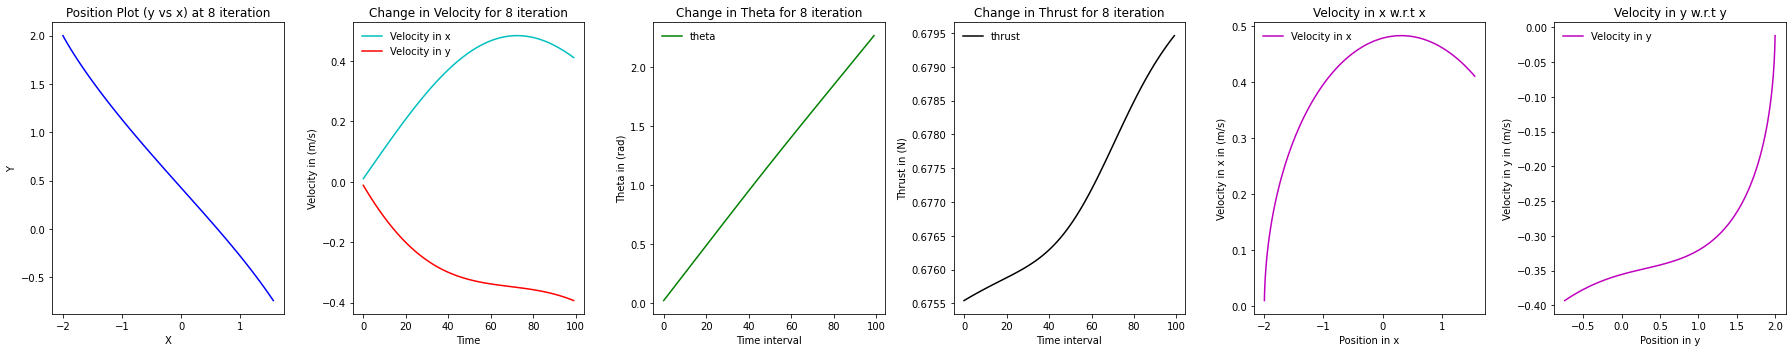

[9] loss: 1.621


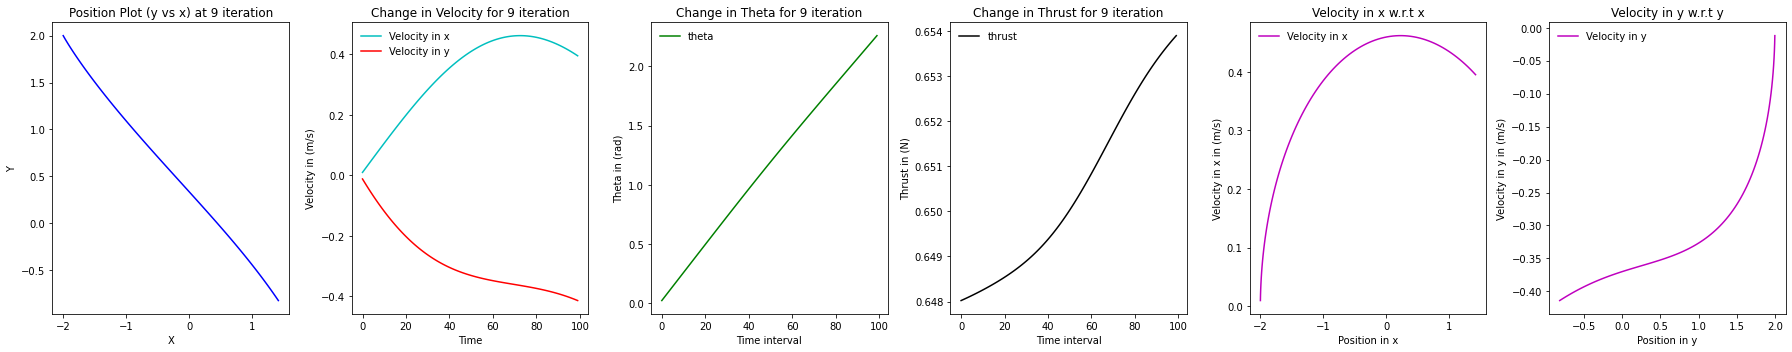

[10] loss: 1.547


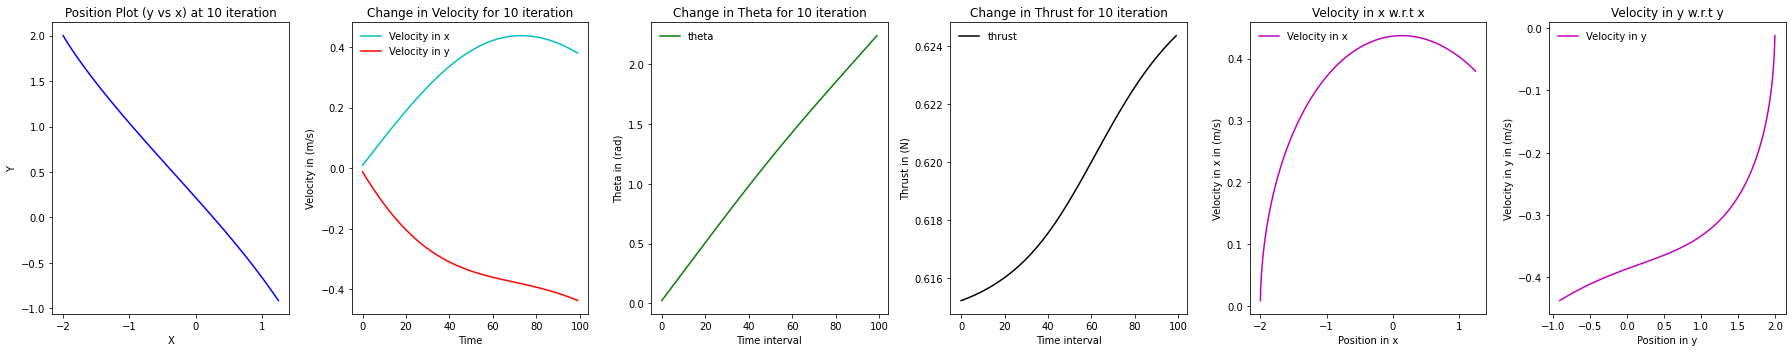

[11] loss: 1.442


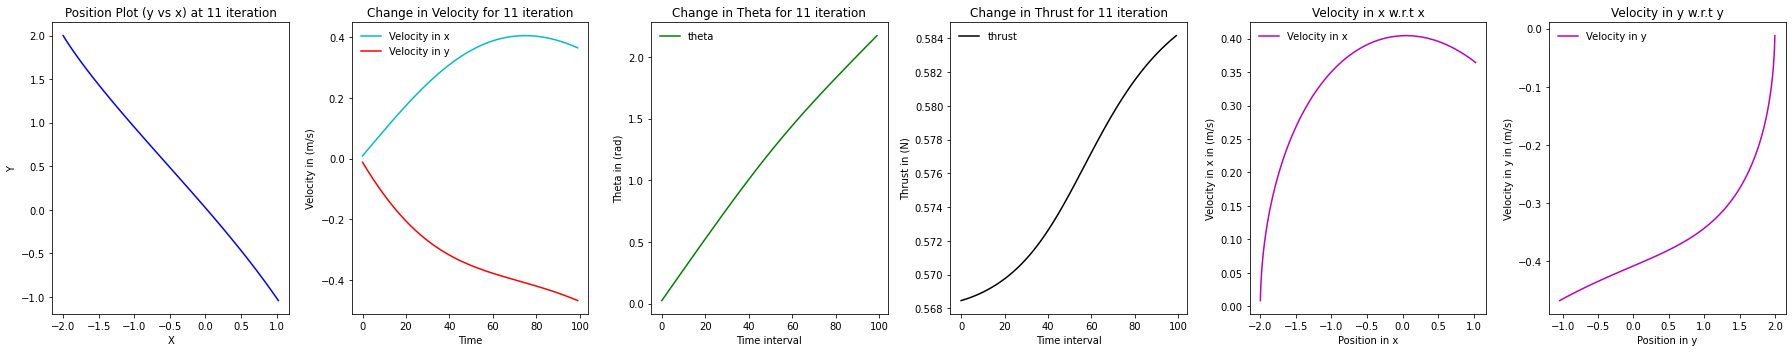

[12] loss: 0.991


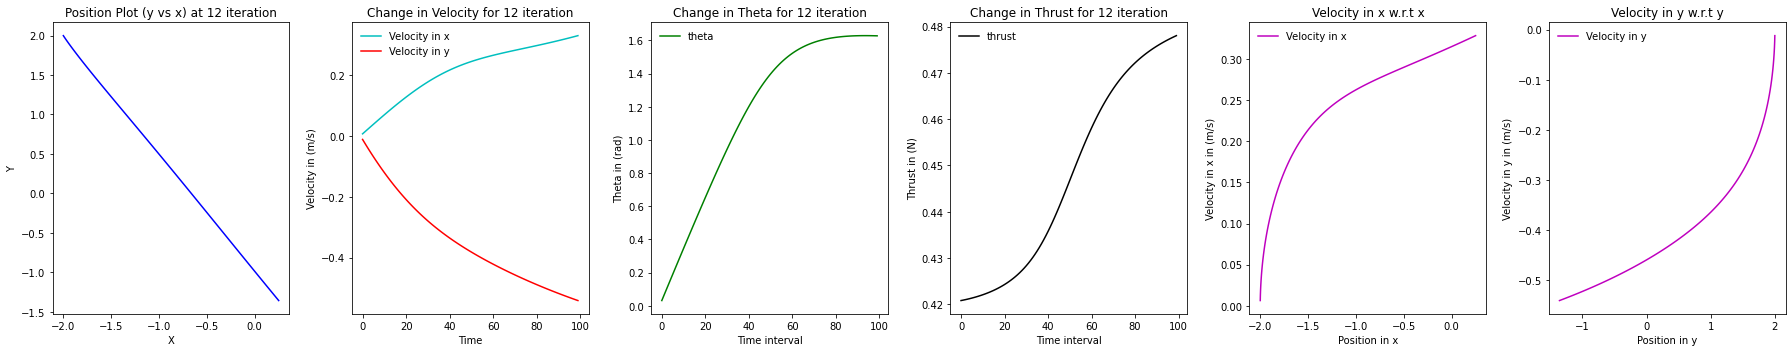

[13] loss: 0.673


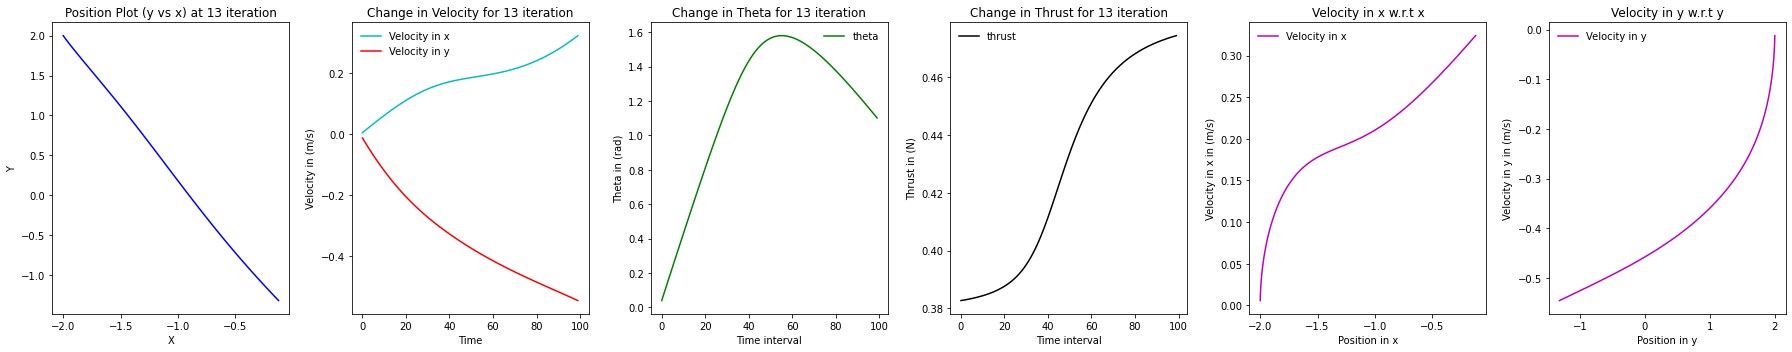

[14] loss: 0.468


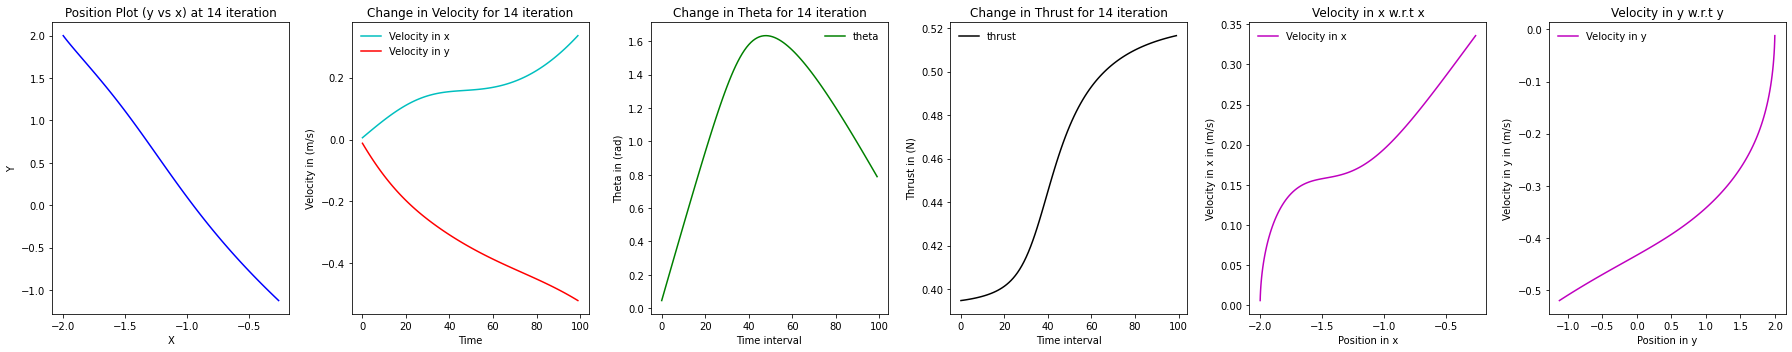

[15] loss: 0.298


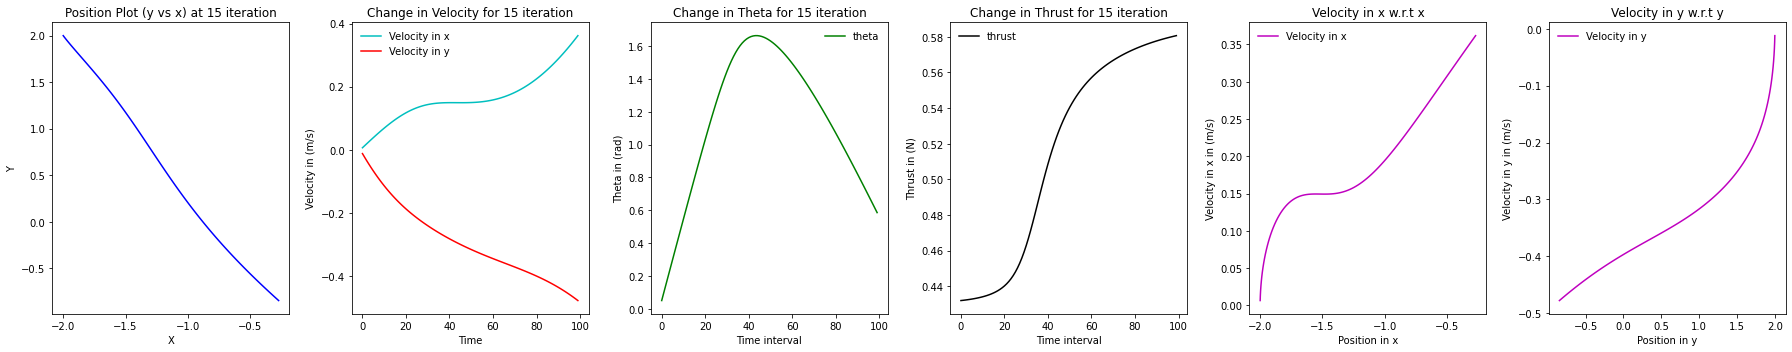

[16] loss: 0.198


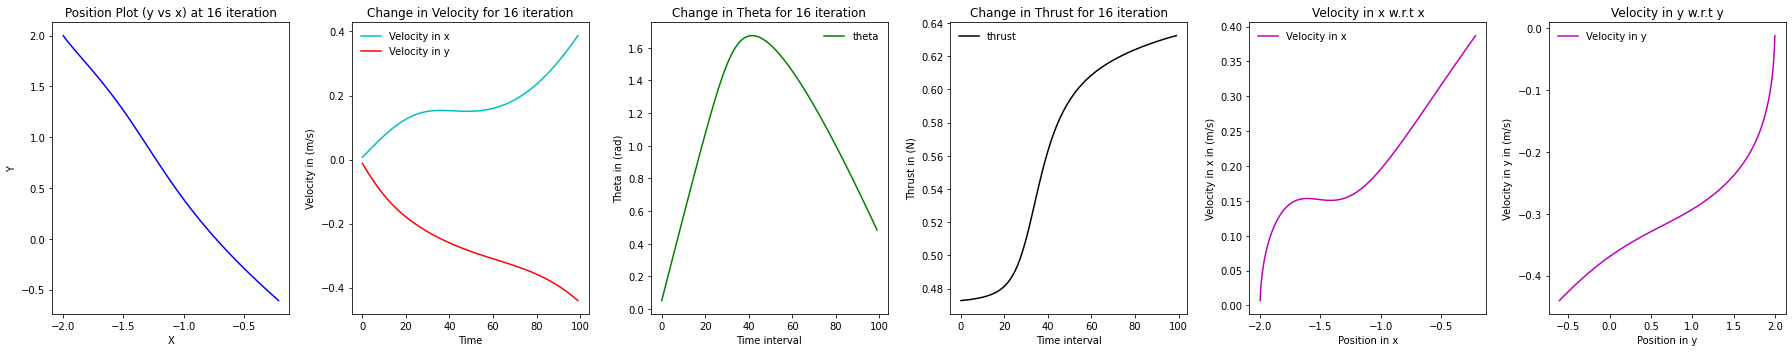

[17] loss: 0.147


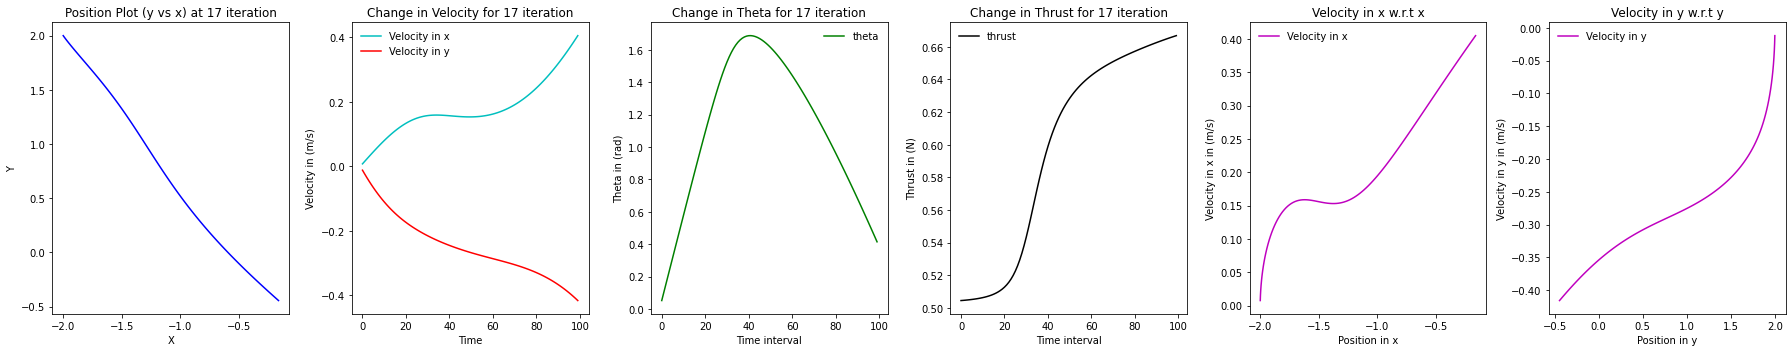

[18] loss: 0.118


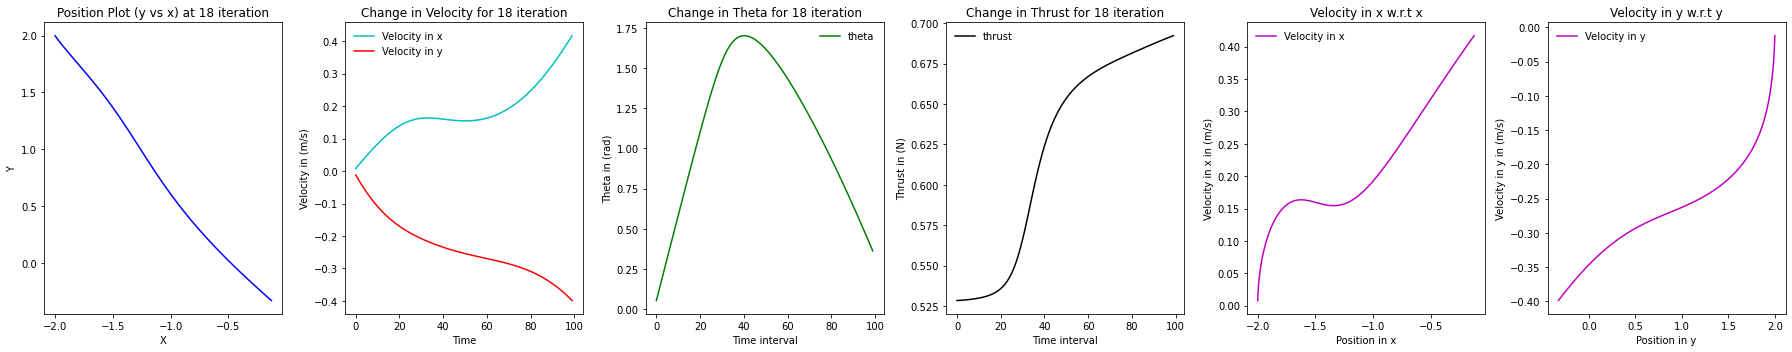

[19] loss: 0.101


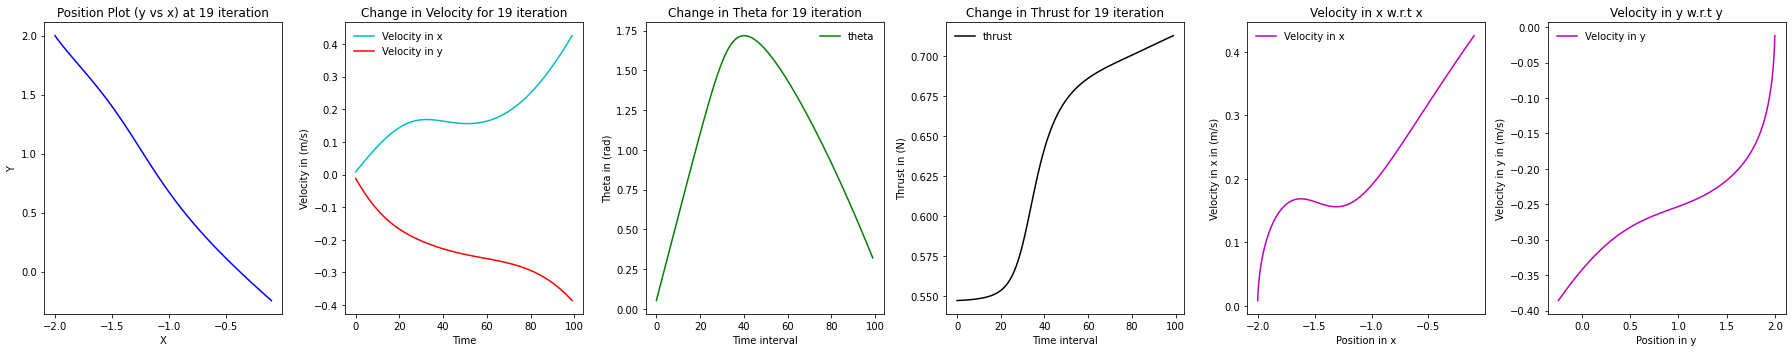

[20] loss: 0.090


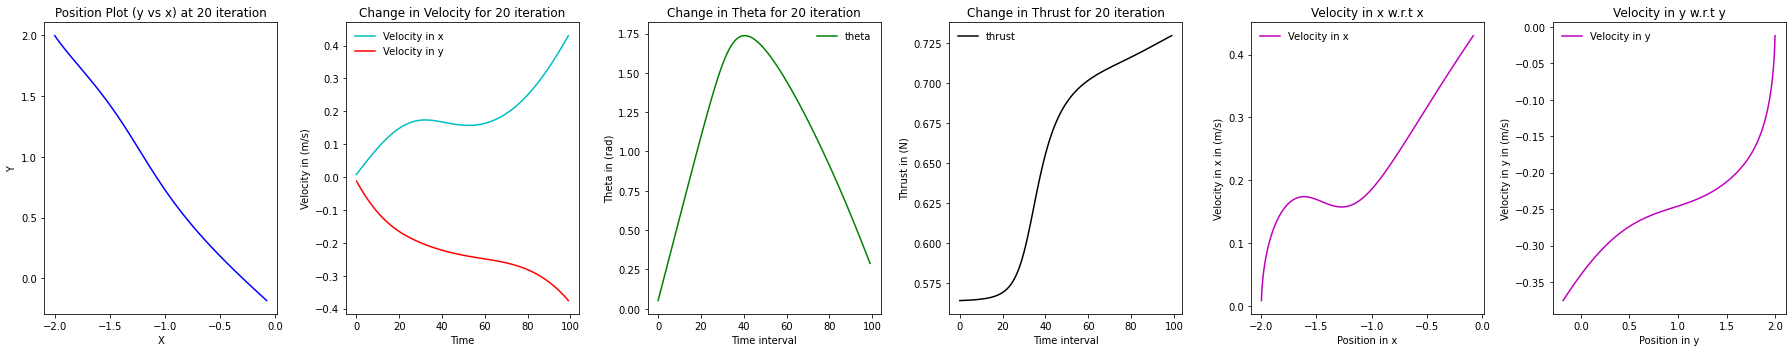

[21] loss: 0.082


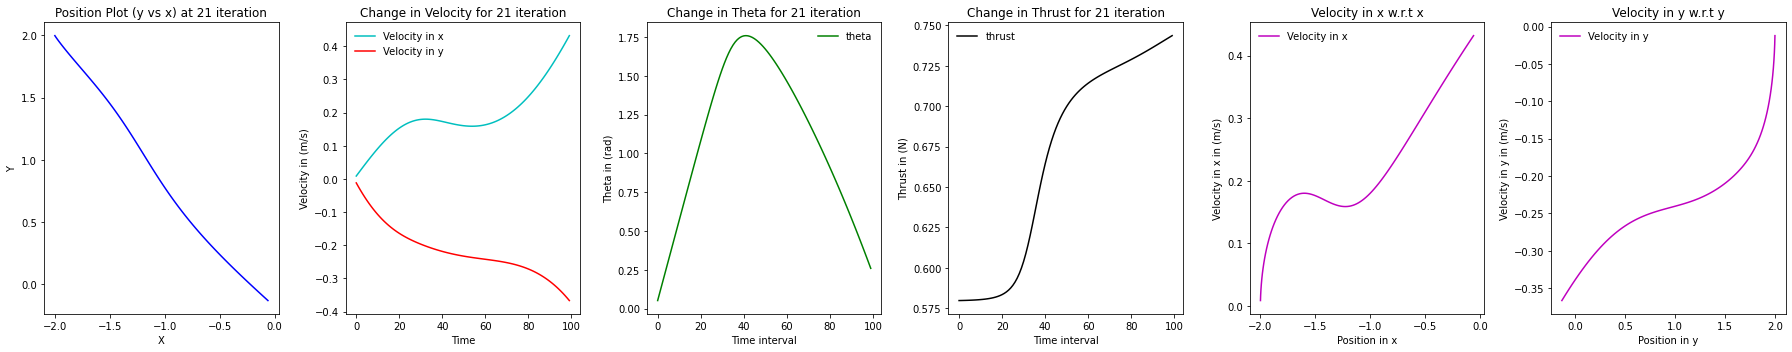

[22] loss: 0.076


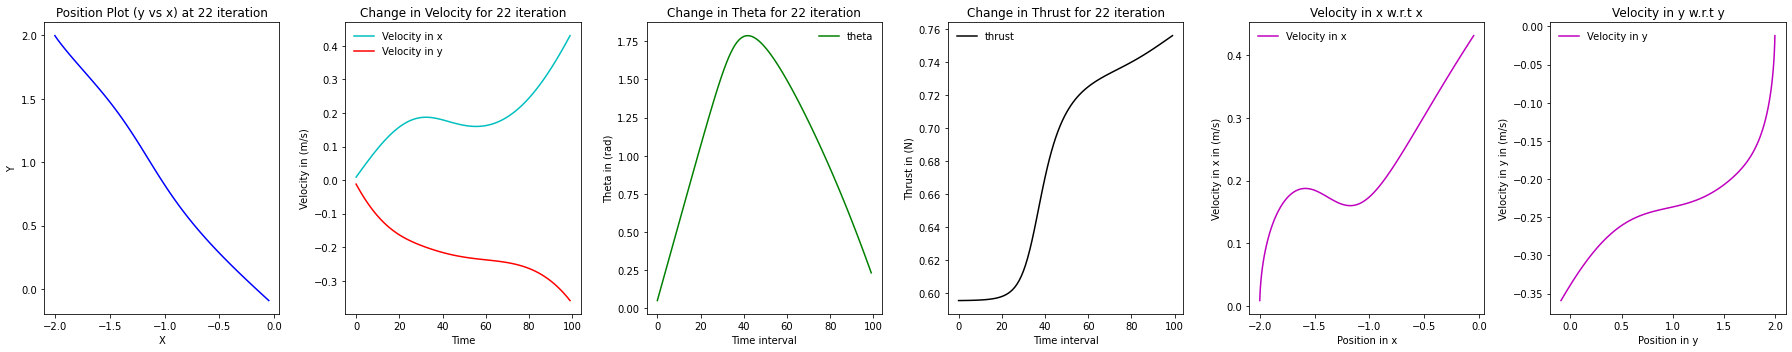

[23] loss: 0.071


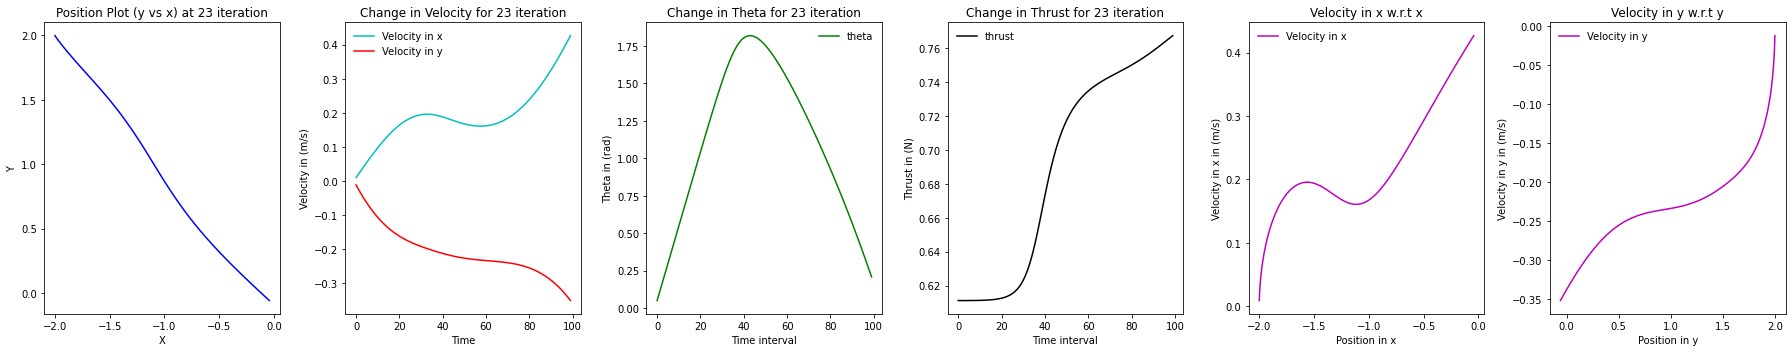

[24] loss: 0.066


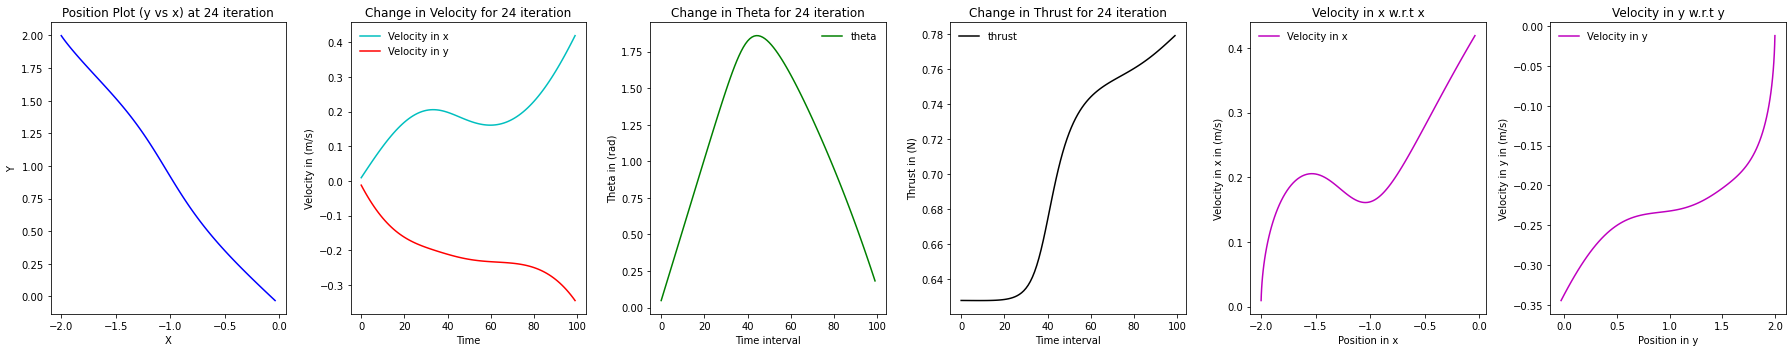

[25] loss: 0.061


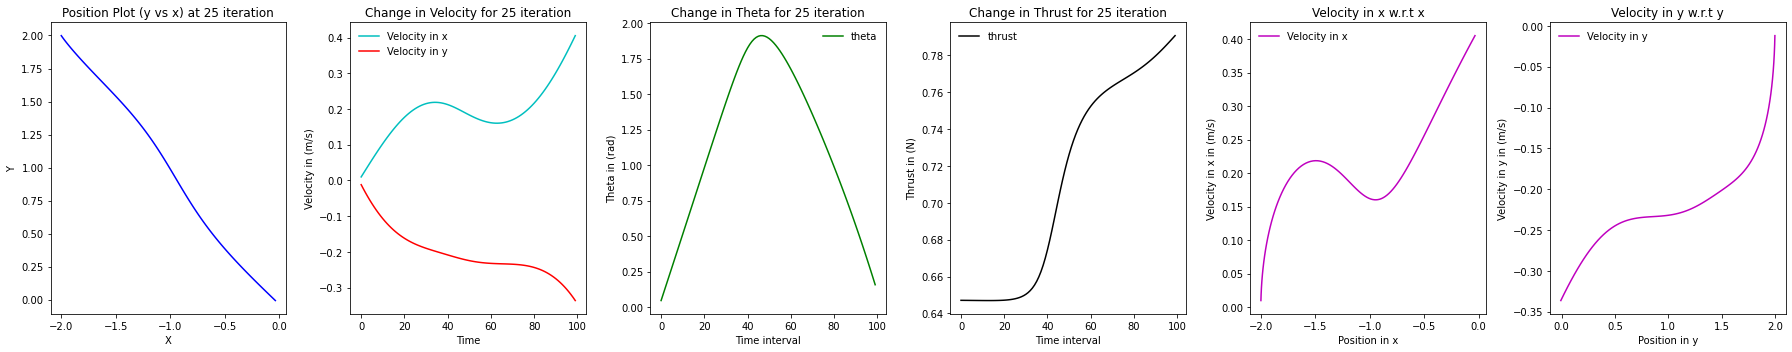

[26] loss: 0.055


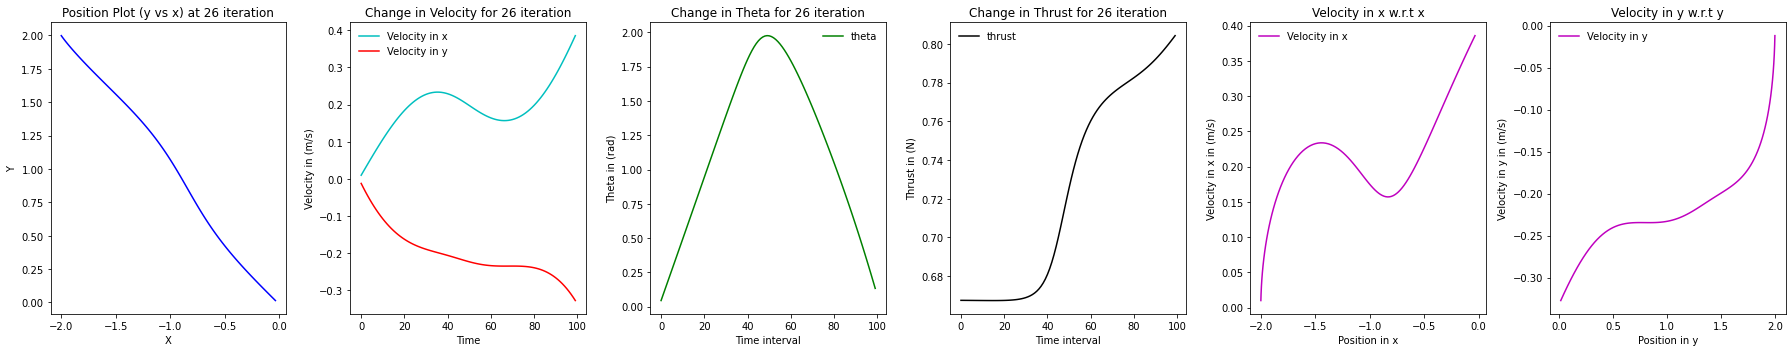

[27] loss: 0.048


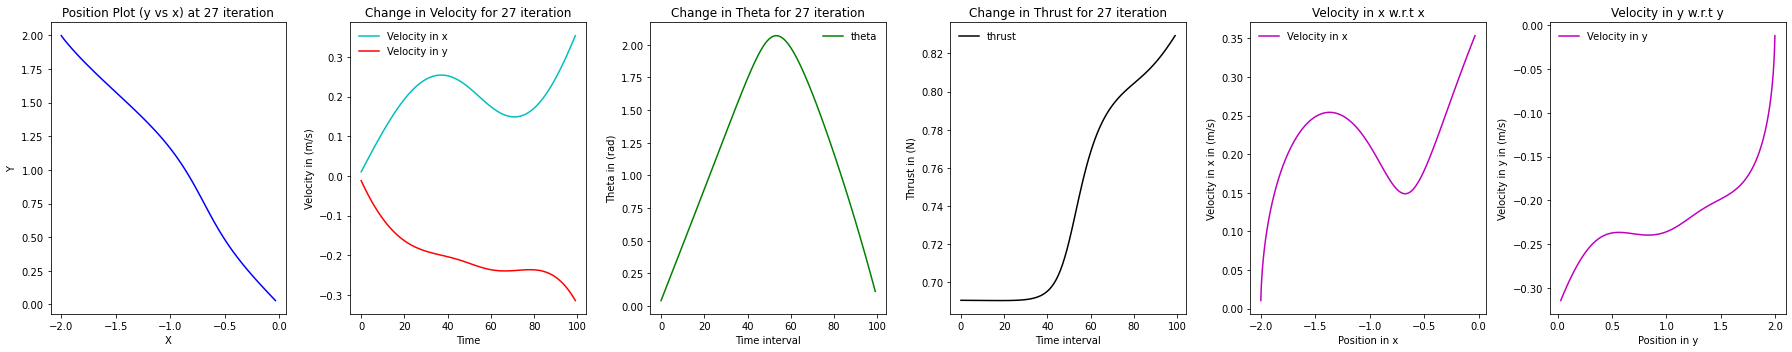

[28] loss: 0.041


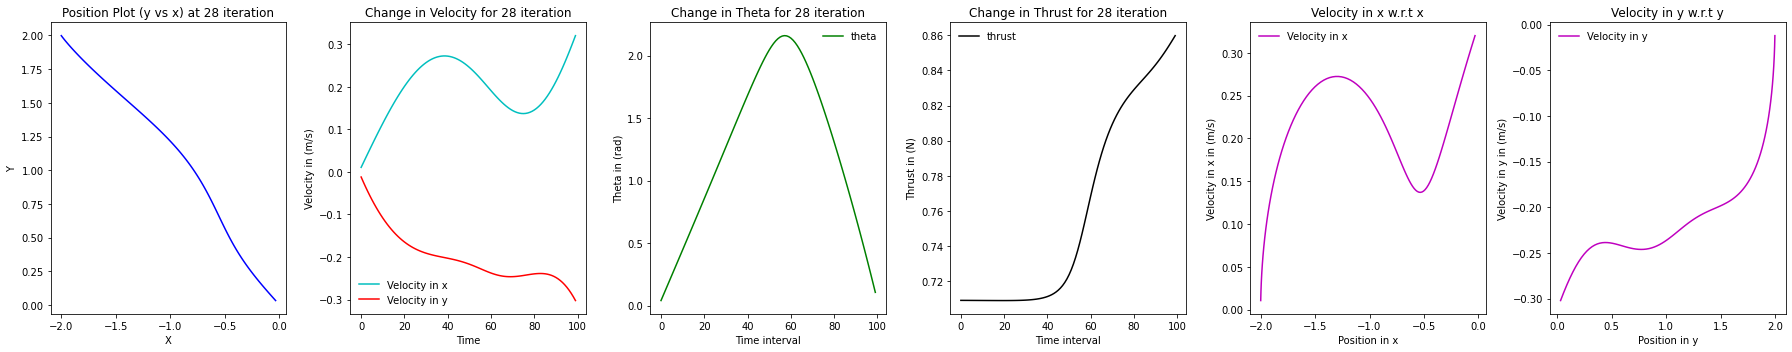

[29] loss: 0.037


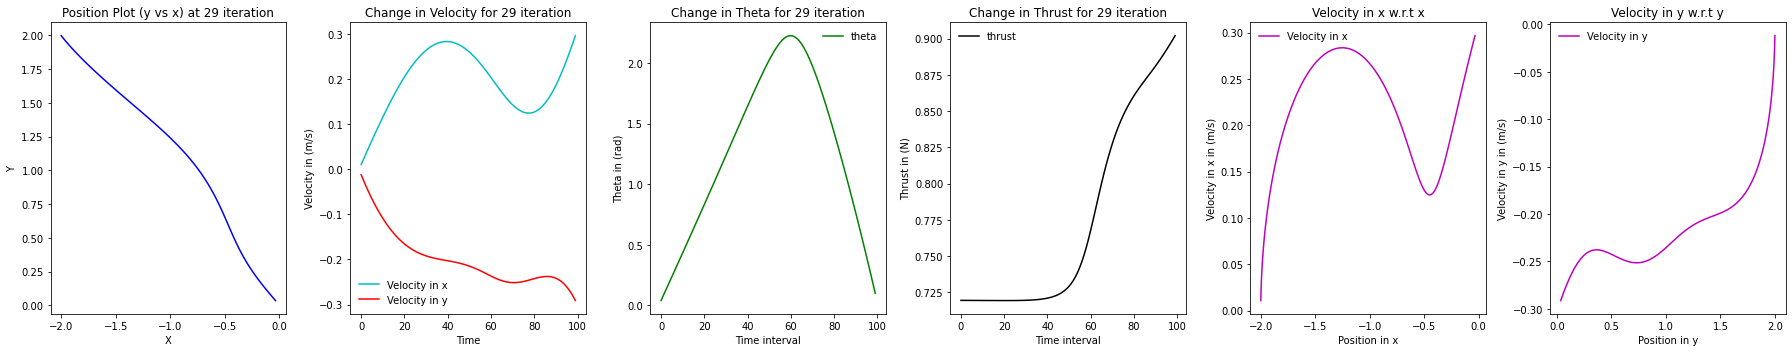

[30] loss: 0.034


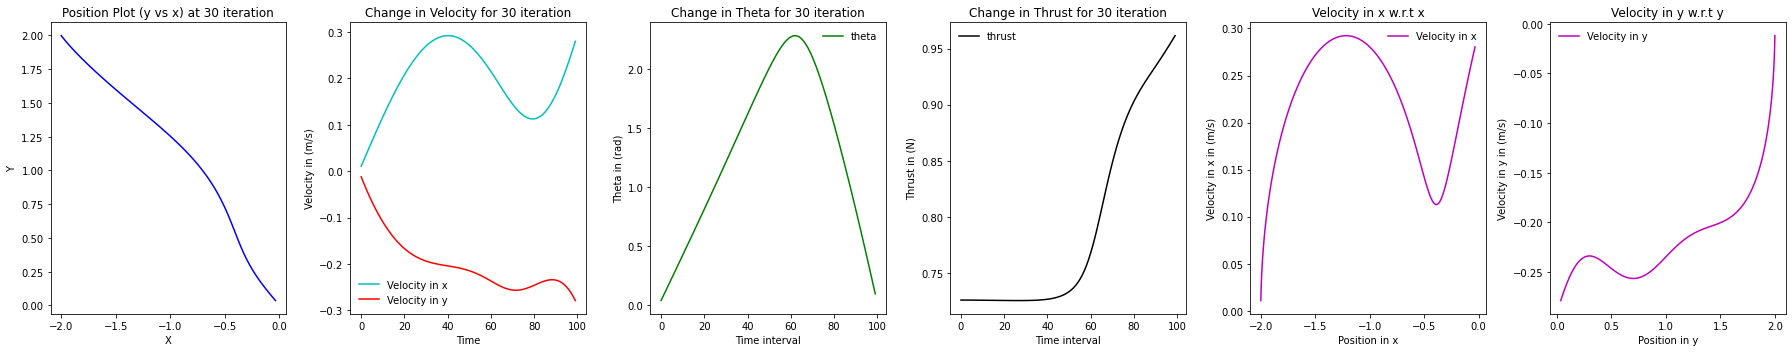

[31] loss: 0.031


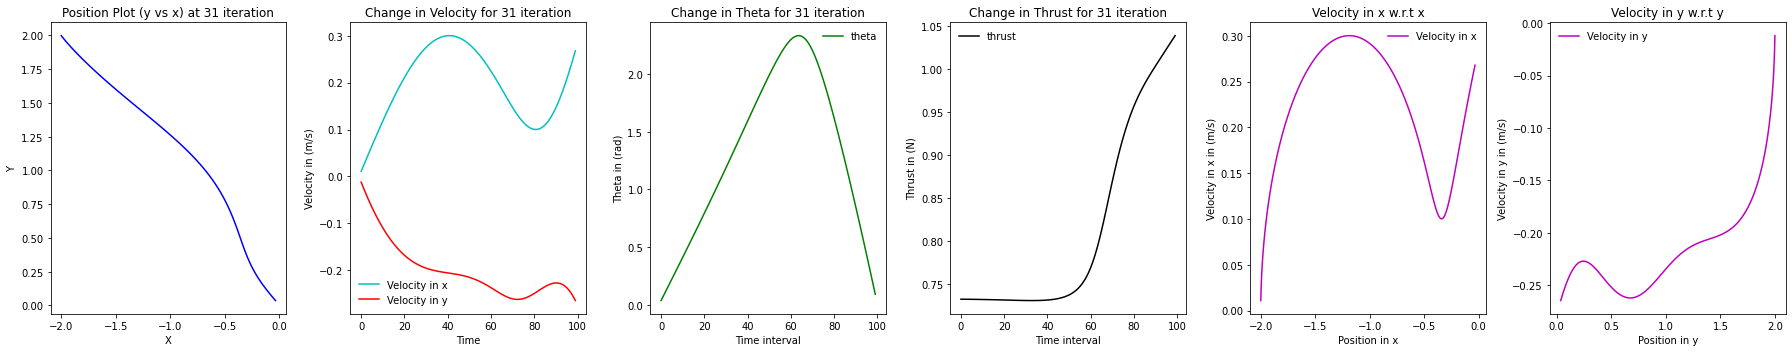

[32] loss: 0.028


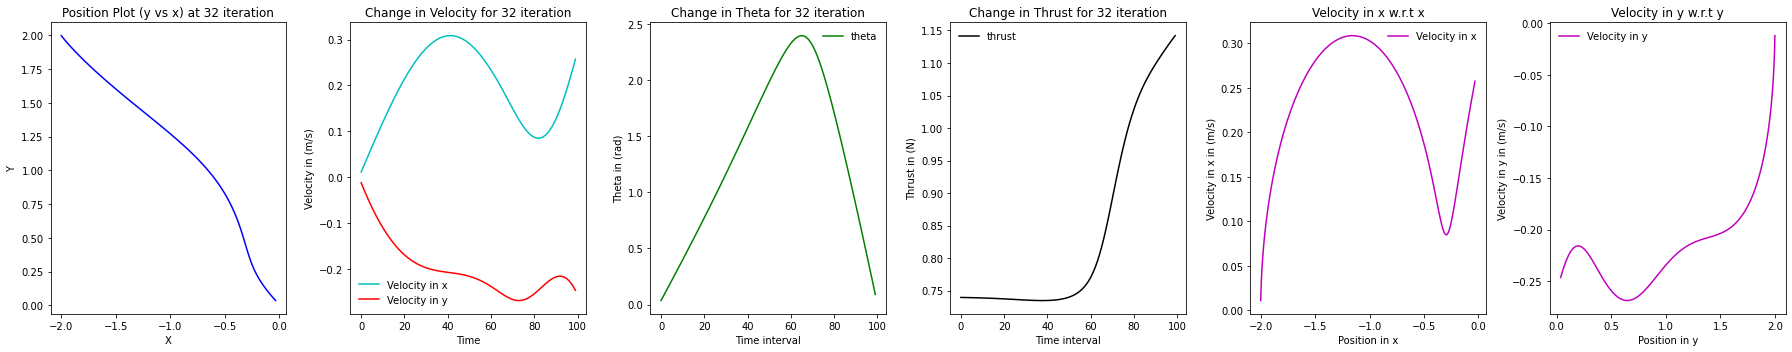

[33] loss: 0.024


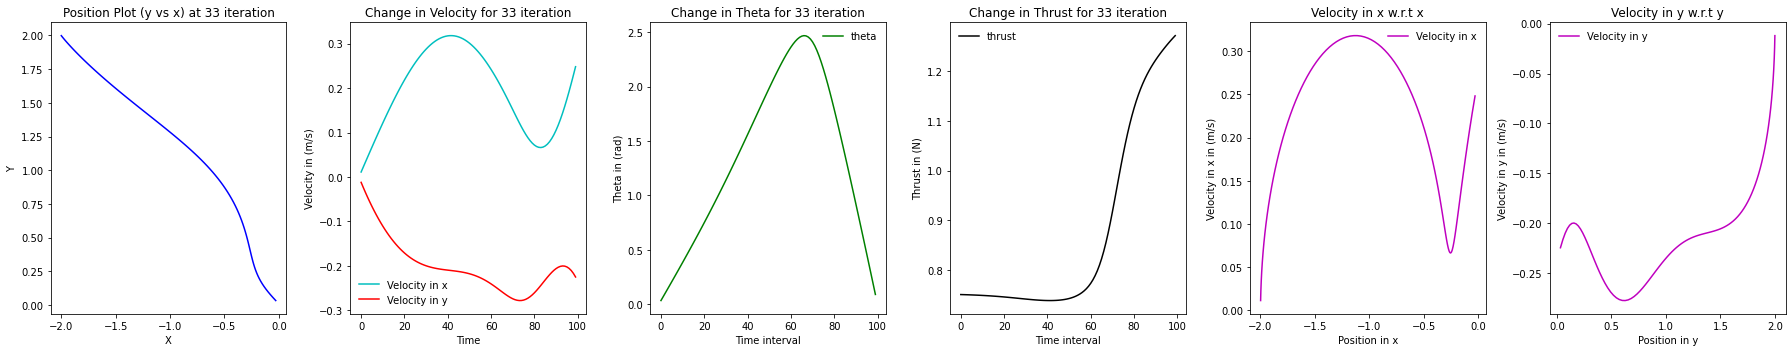

[34] loss: 0.021


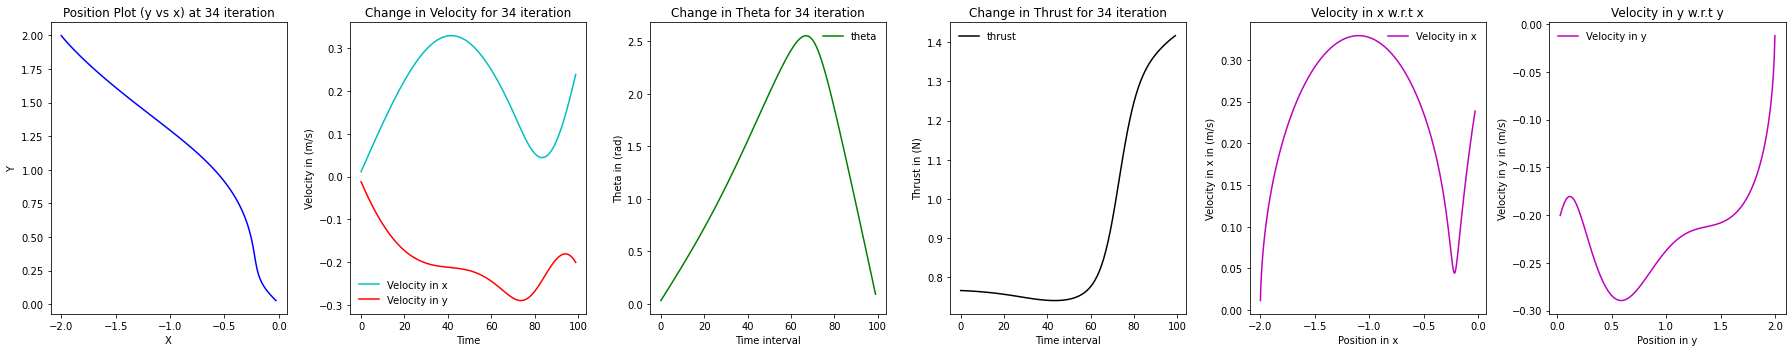

[35] loss: 0.019


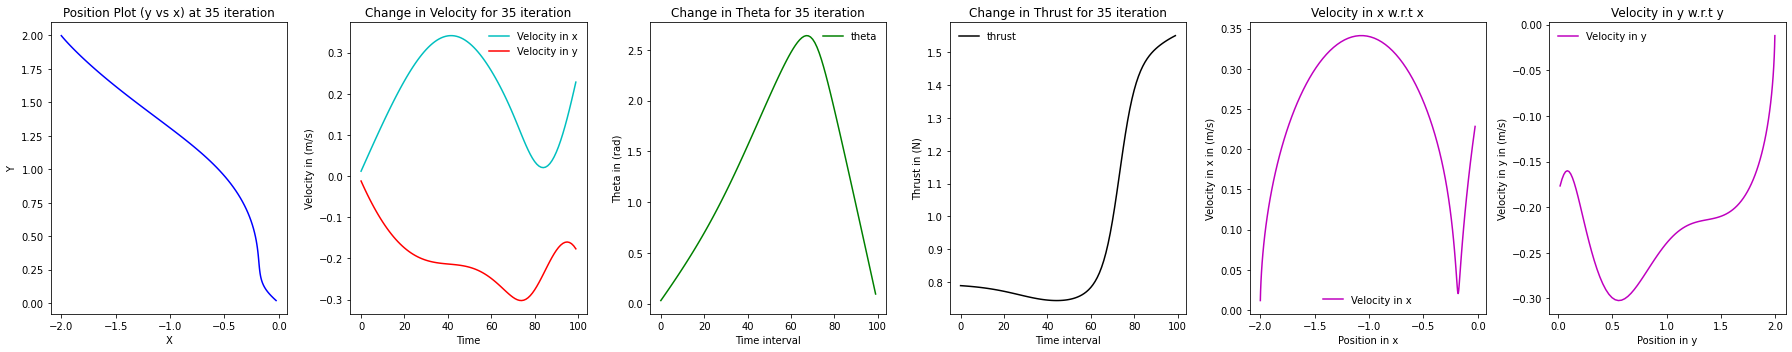

[36] loss: 0.016


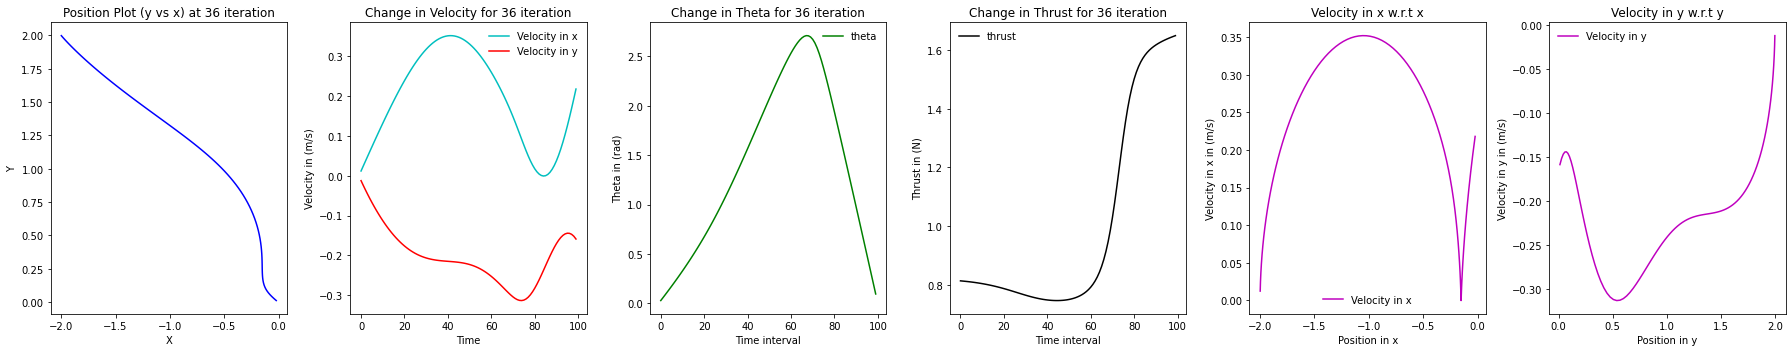

[37] loss: 0.015


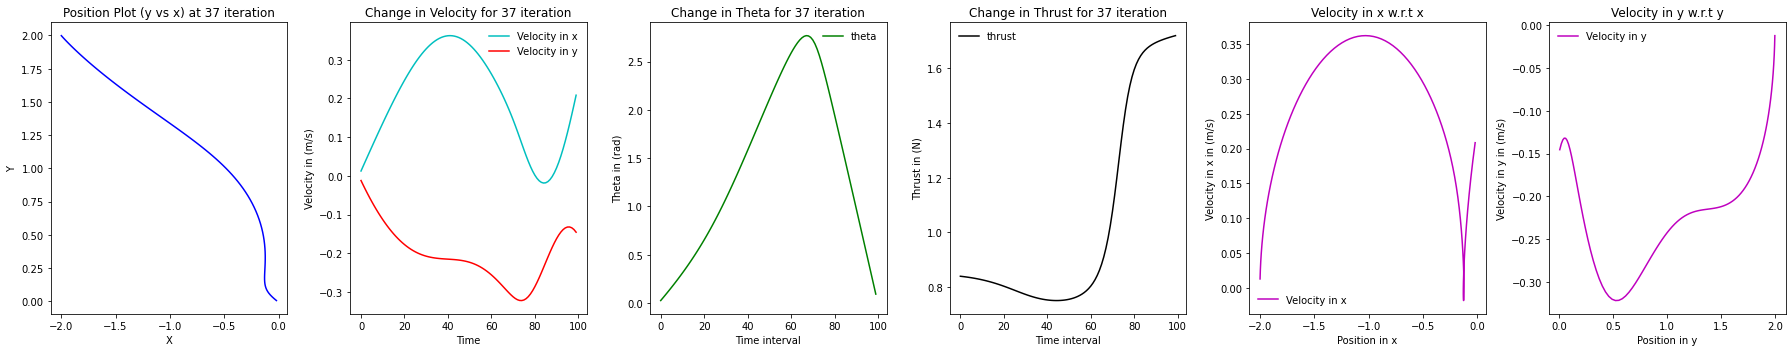

[38] loss: 0.013


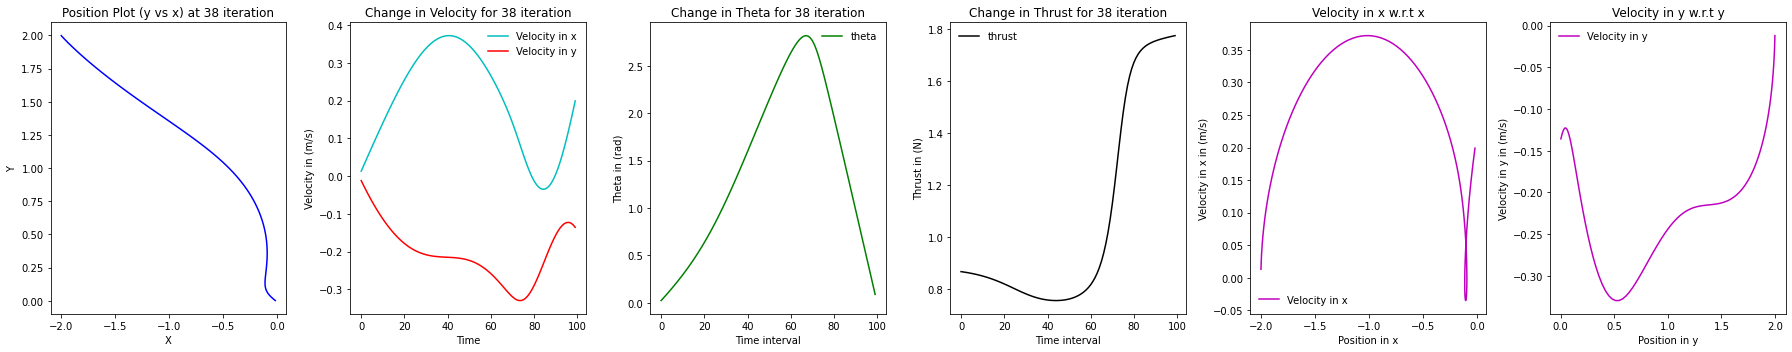

[39] loss: 0.012


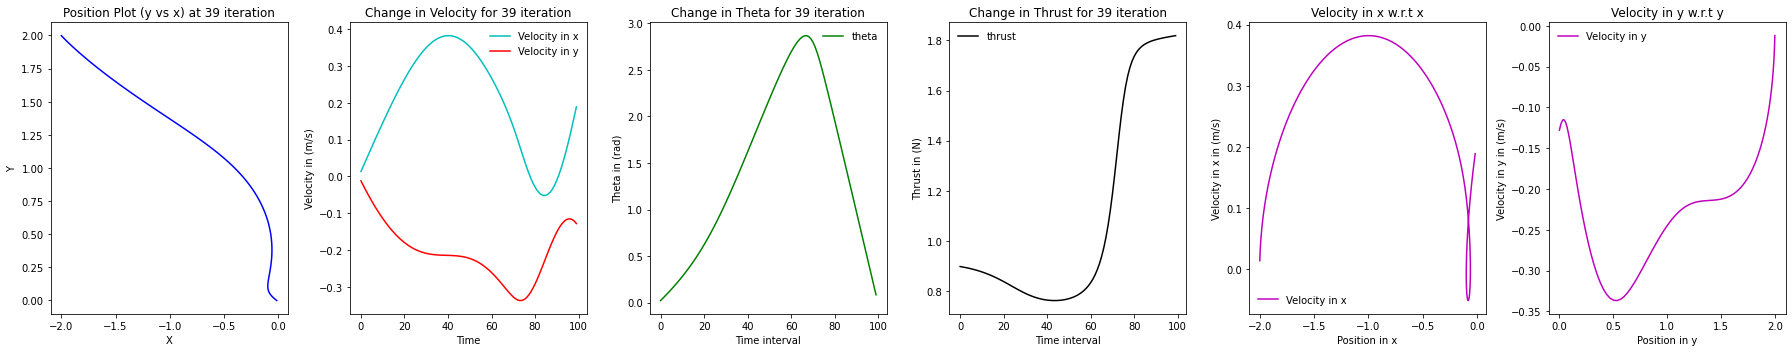

[40] loss: 0.011


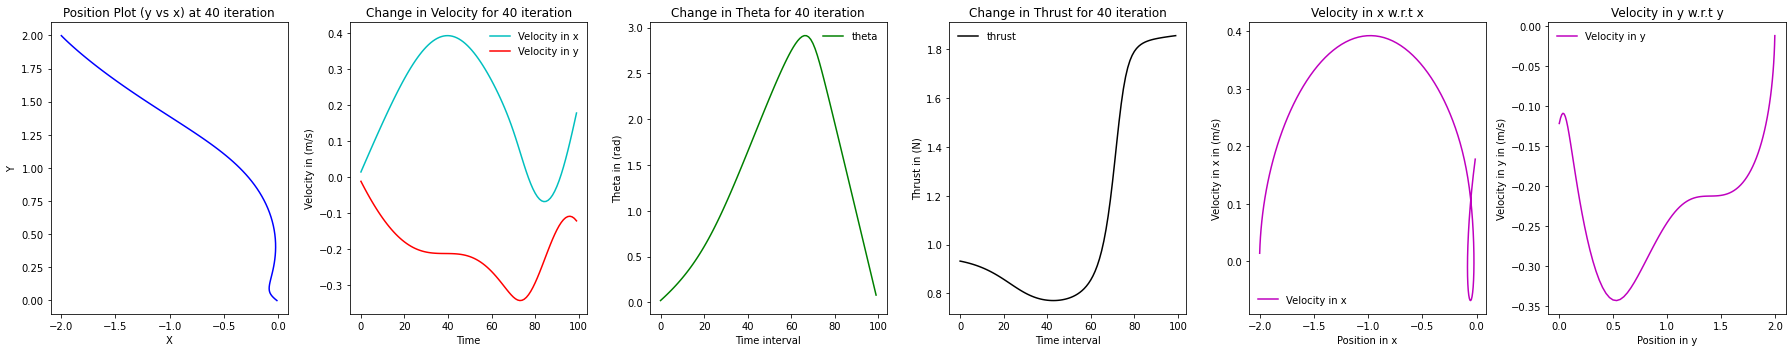

[41] loss: 0.010


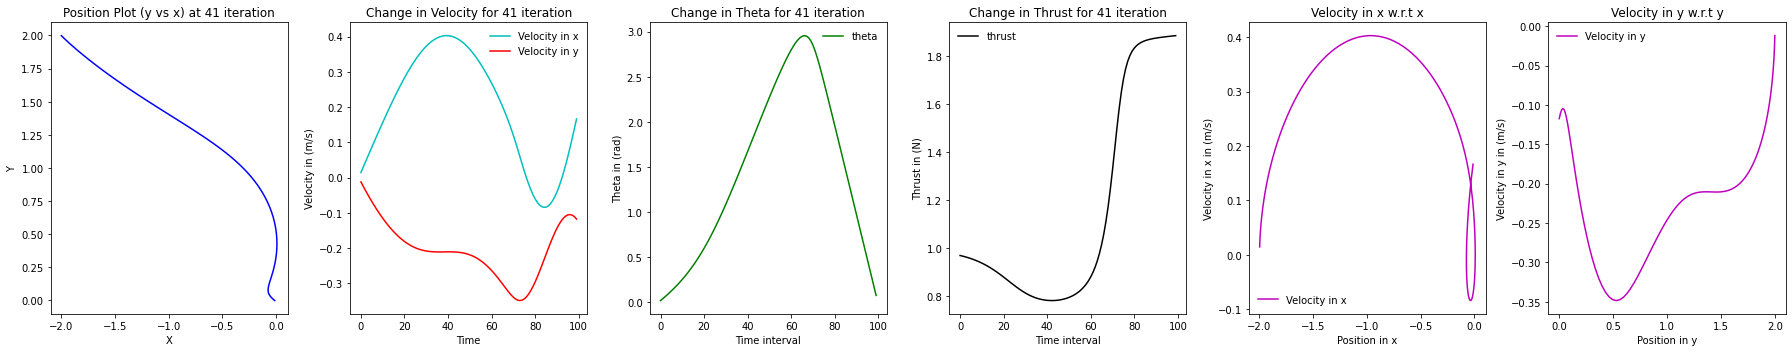

[42] loss: 0.009


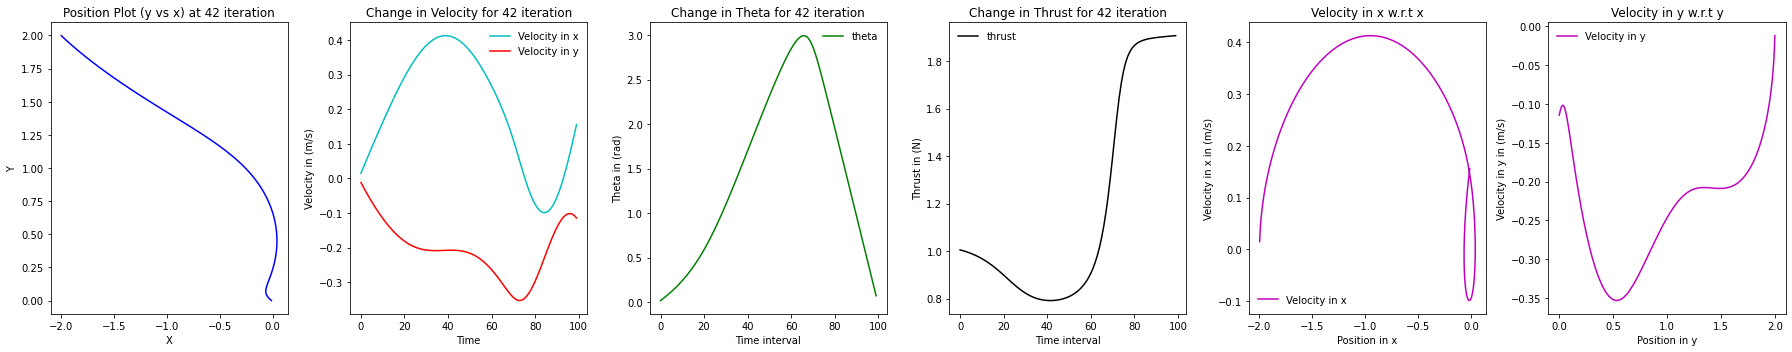

[43] loss: 0.008


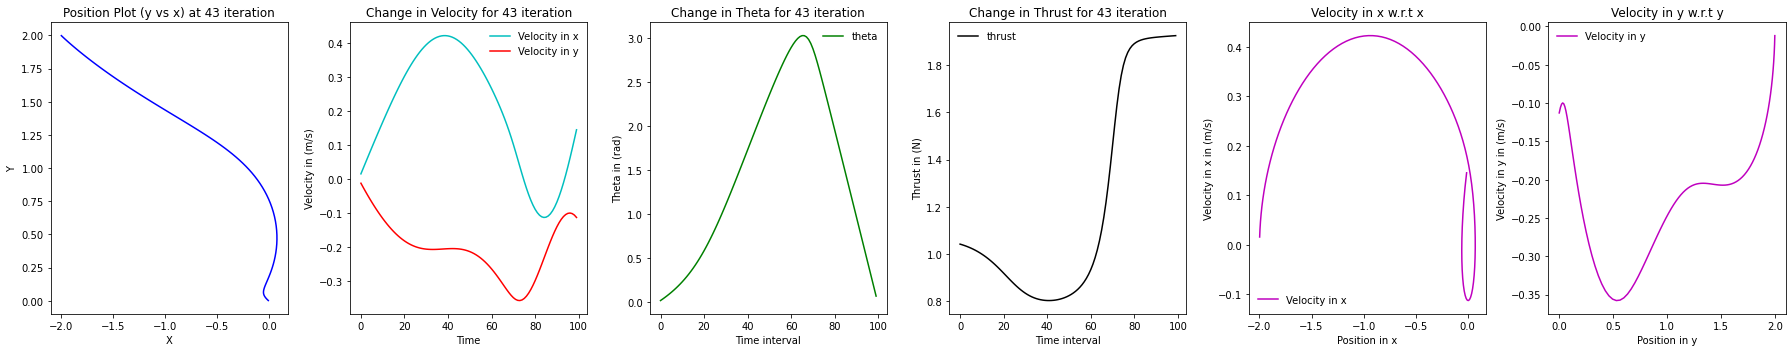

[44] loss: 0.007


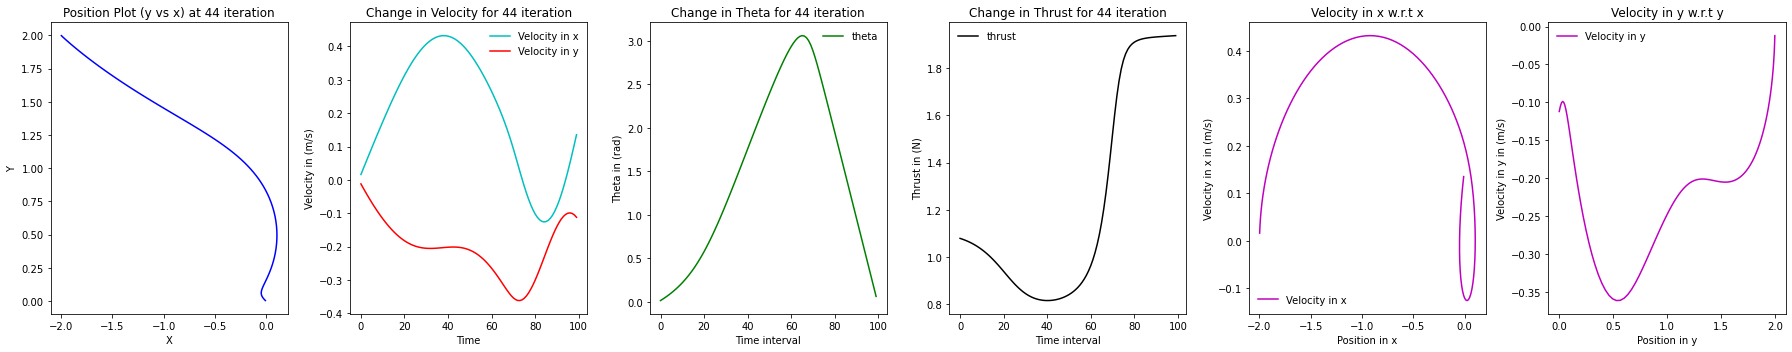

[45] loss: 0.006


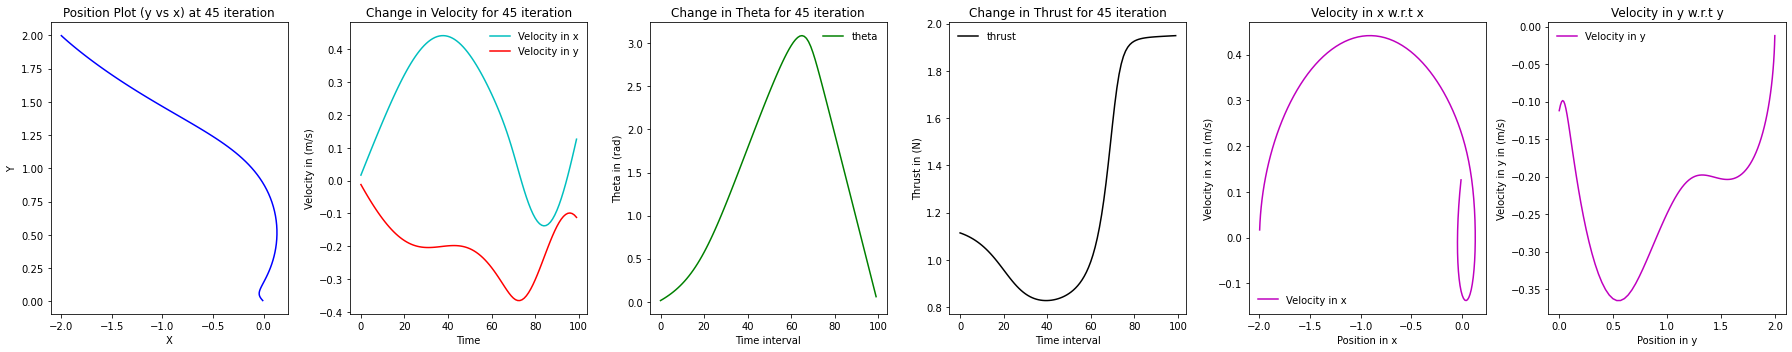

[46] loss: 0.006


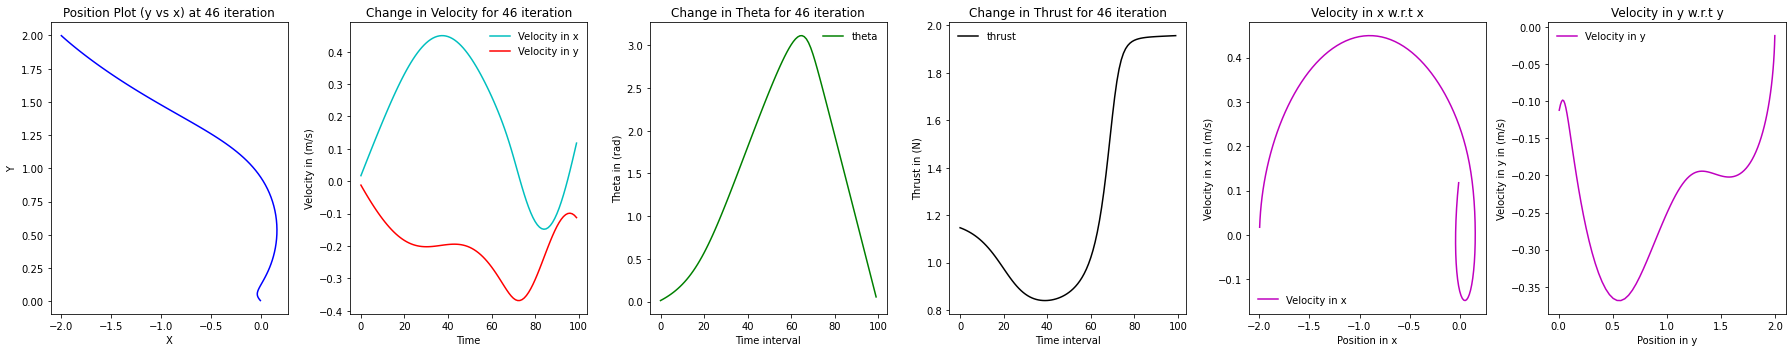

[47] loss: 0.006


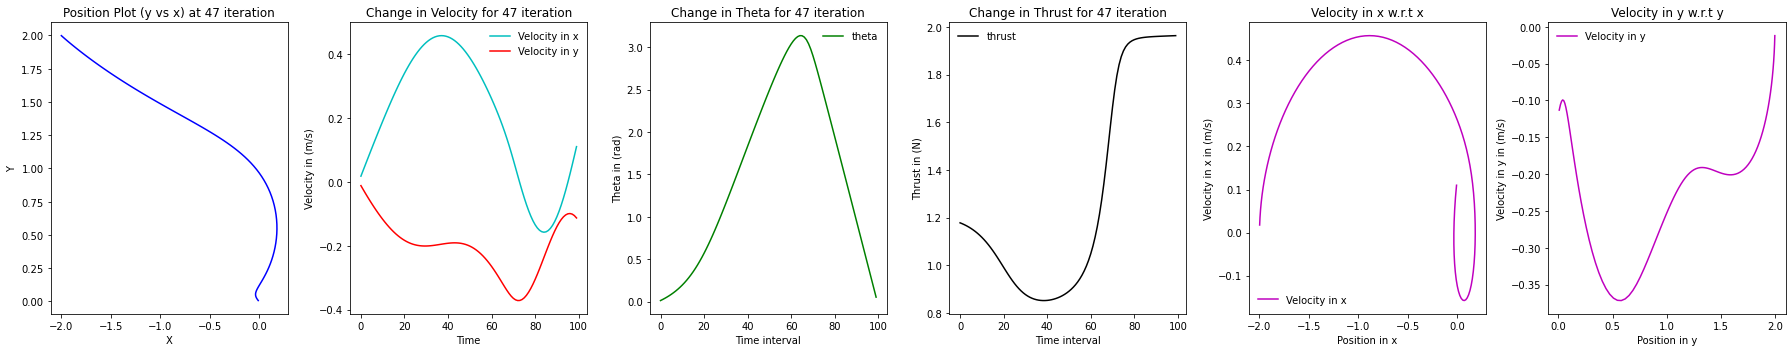

[48] loss: 0.005


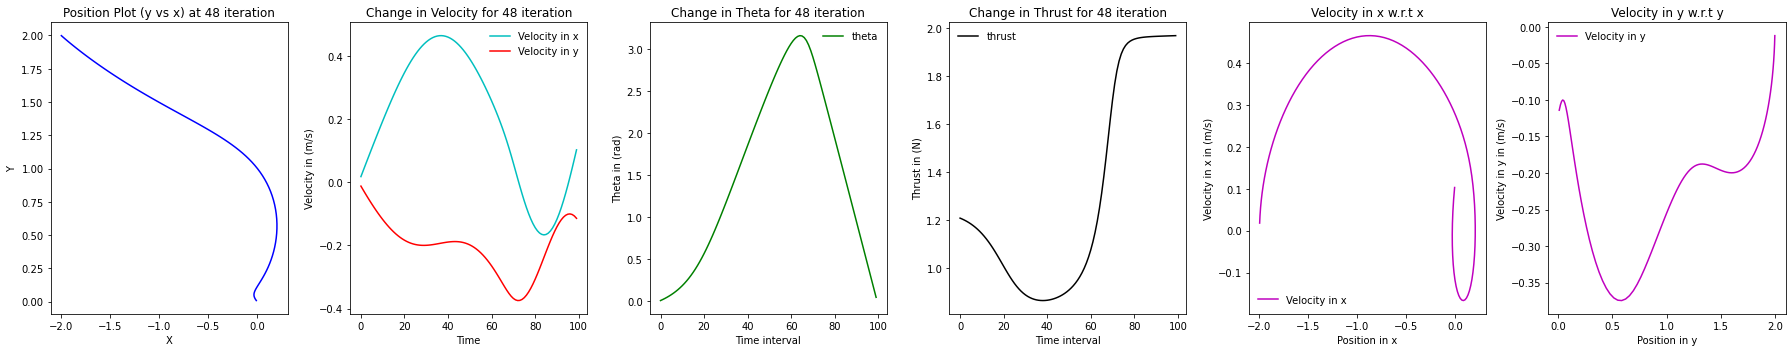

[49] loss: 0.005


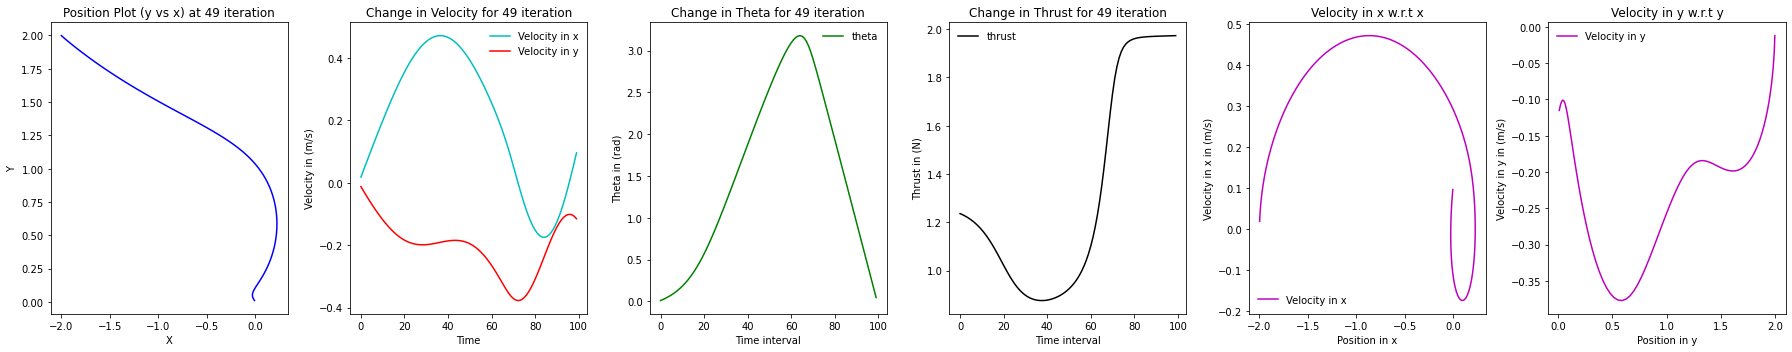

[50] loss: 0.005


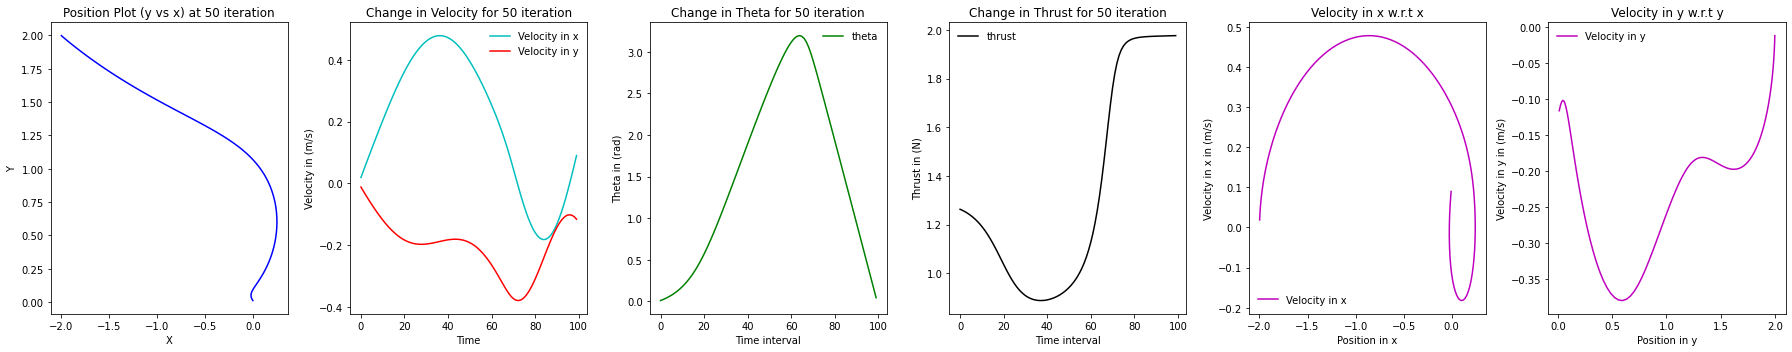

[51] loss: 0.005


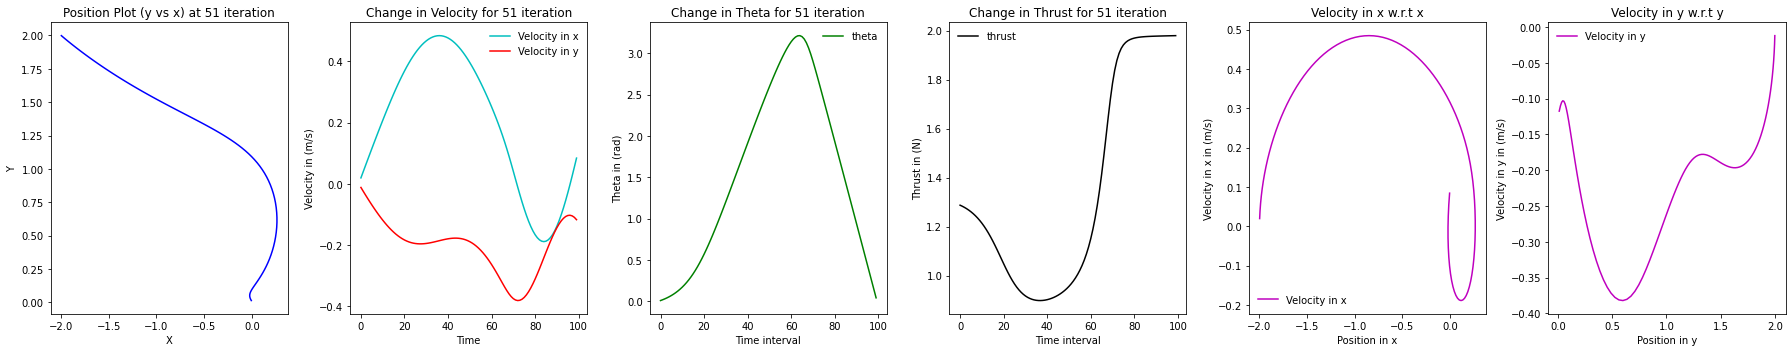

[52] loss: 0.004


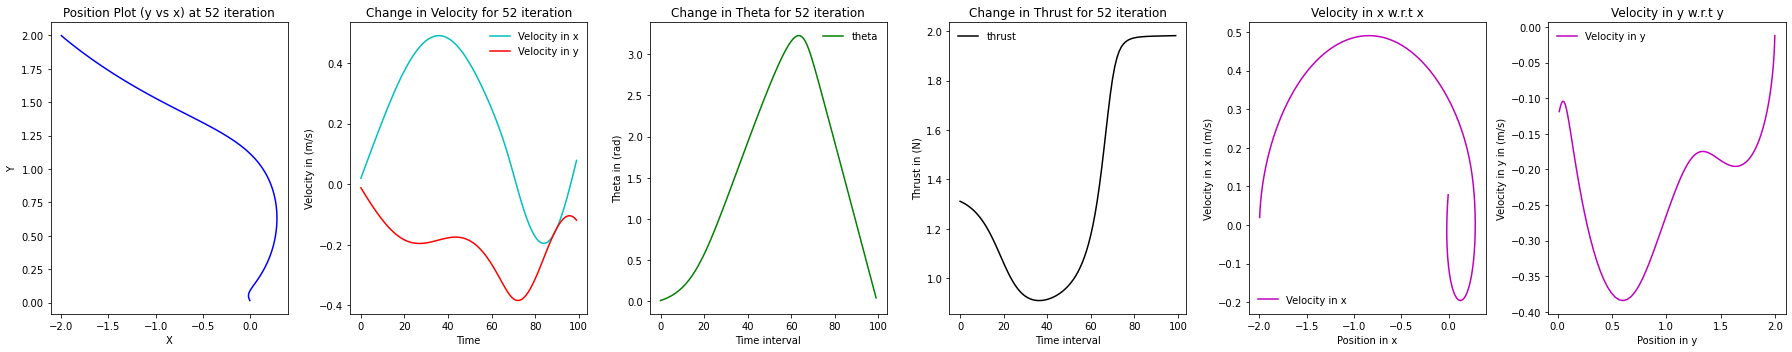

[53] loss: 0.004


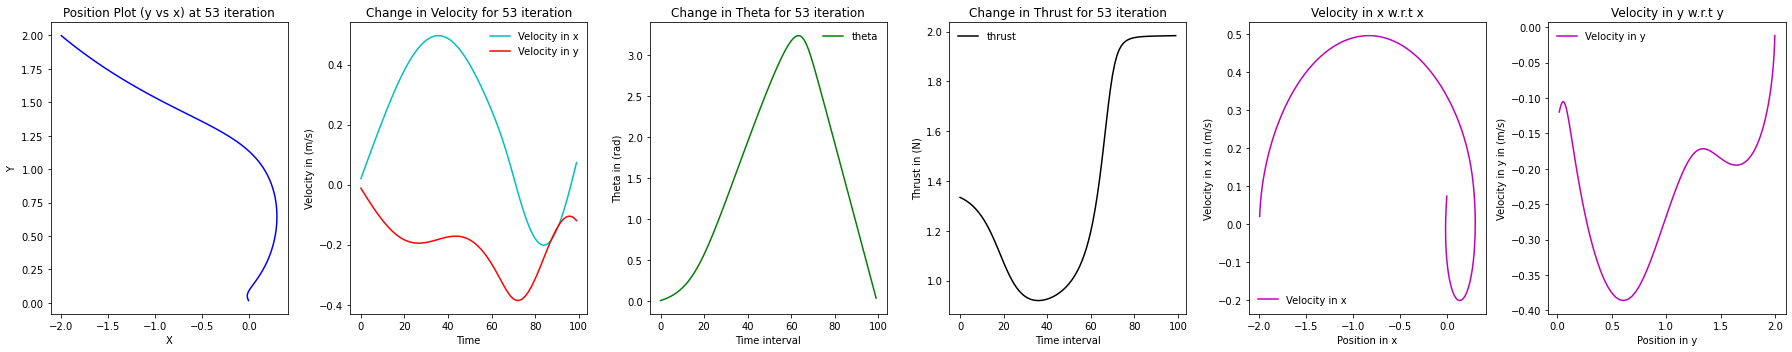

[54] loss: 0.004


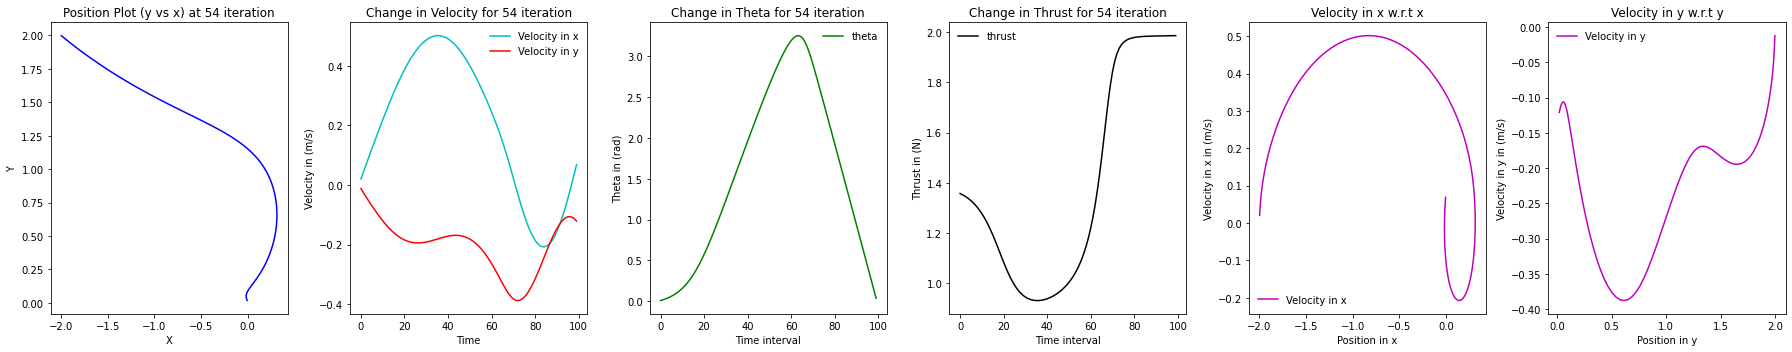

[55] loss: 0.004


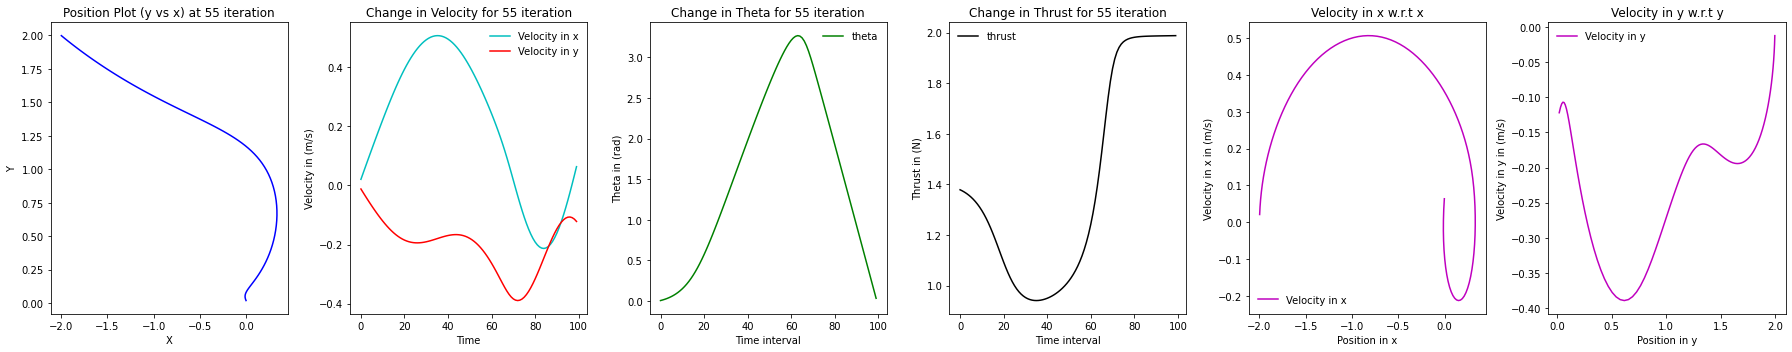

[56] loss: 0.004


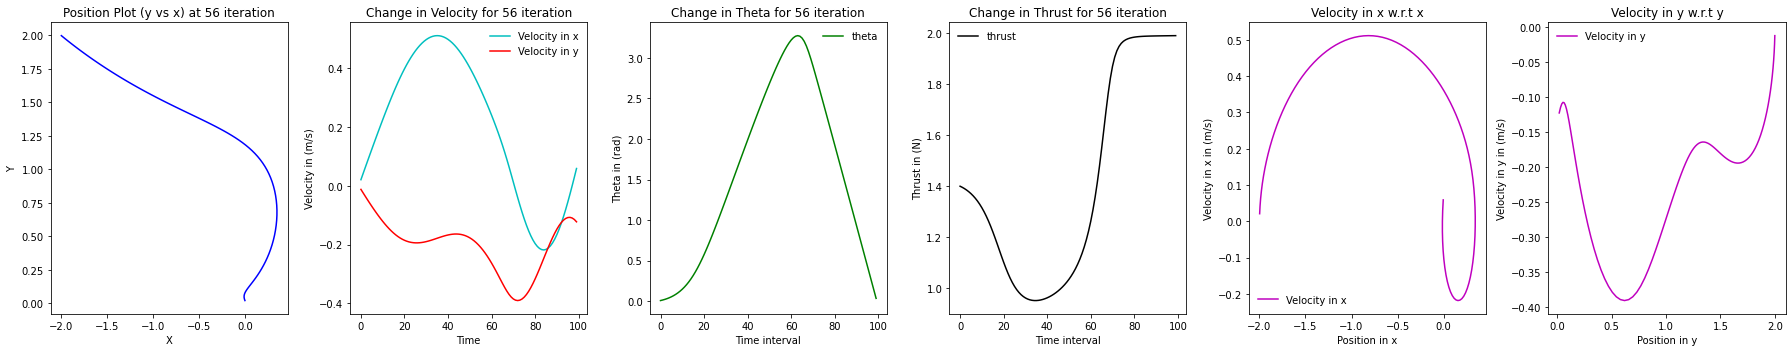

[57] loss: 0.004


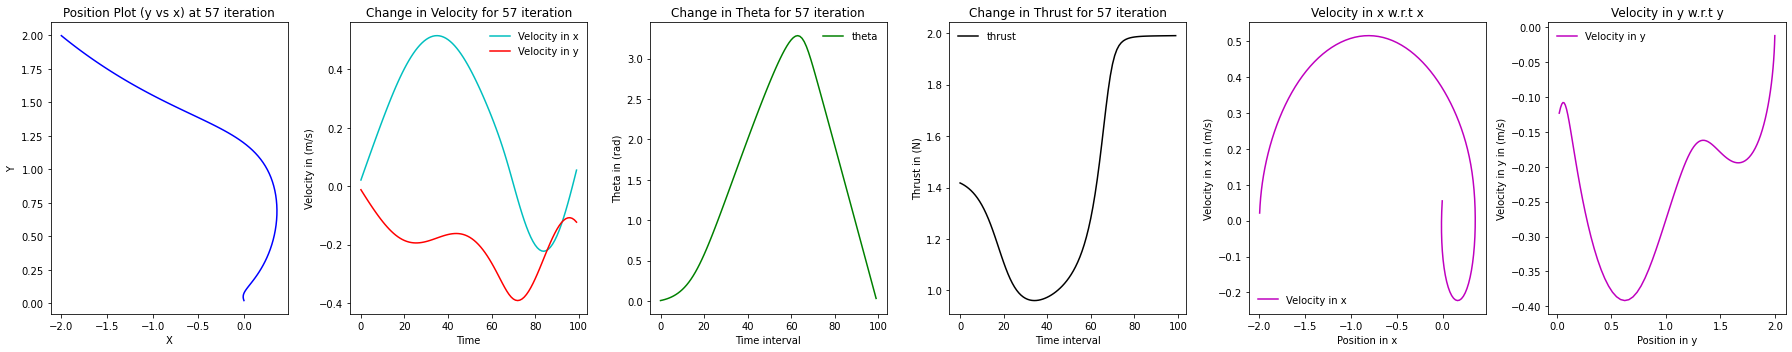

[58] loss: 0.004


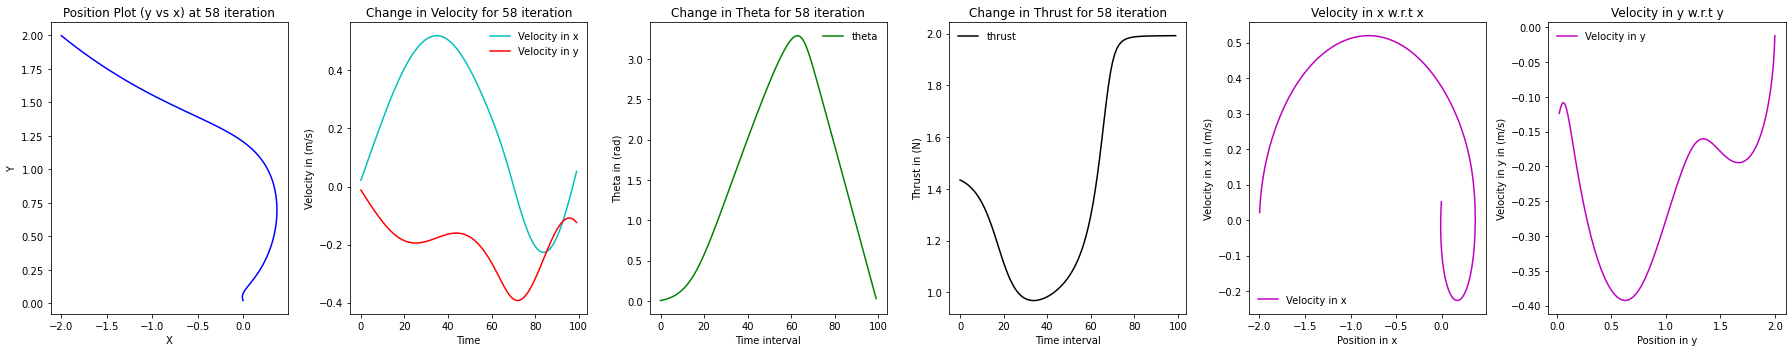

[59] loss: 0.004


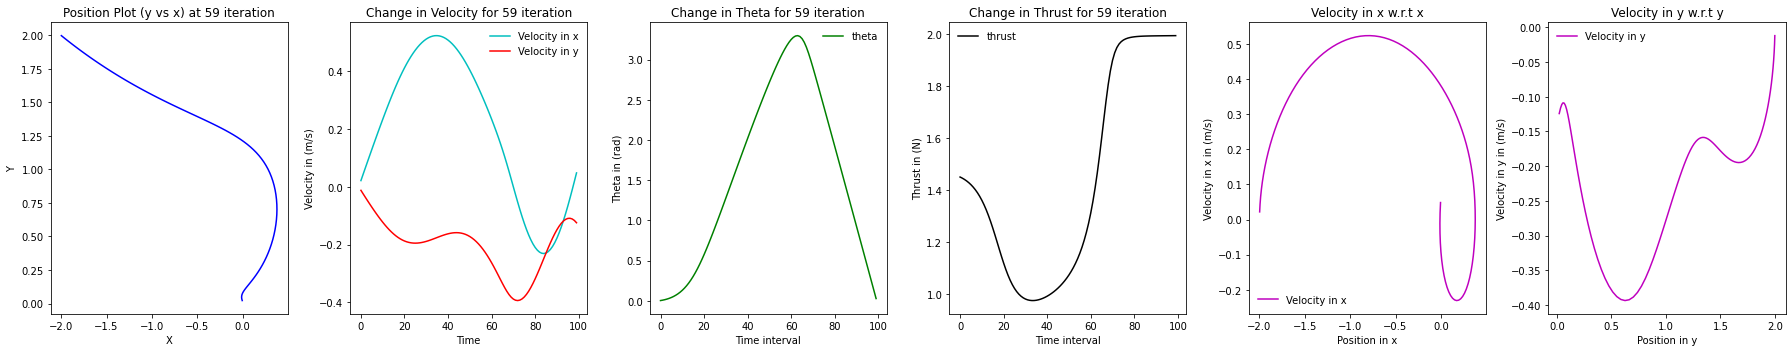

[60] loss: 0.004


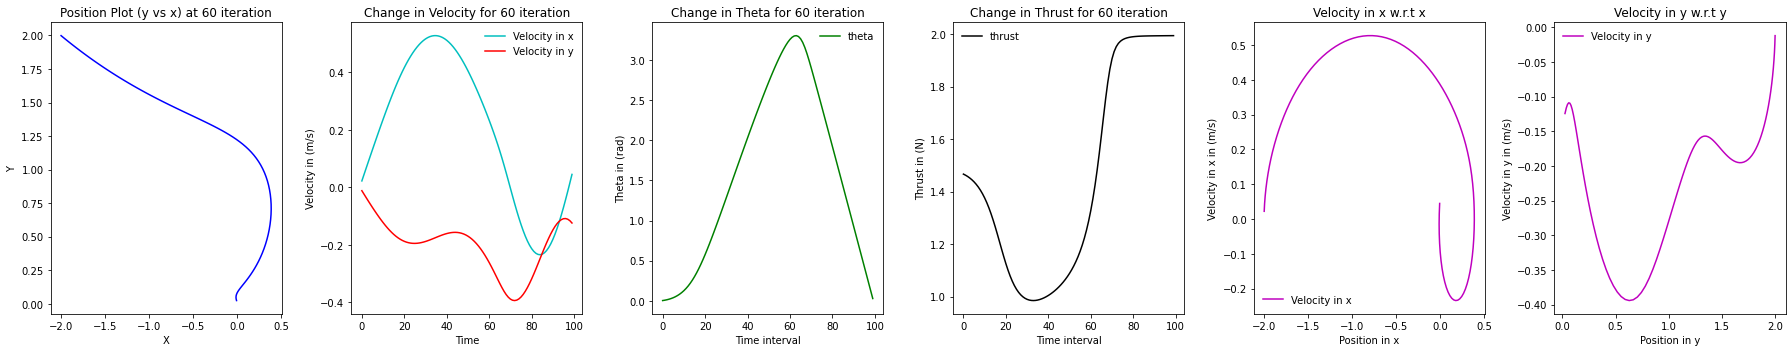

[61] loss: 0.004


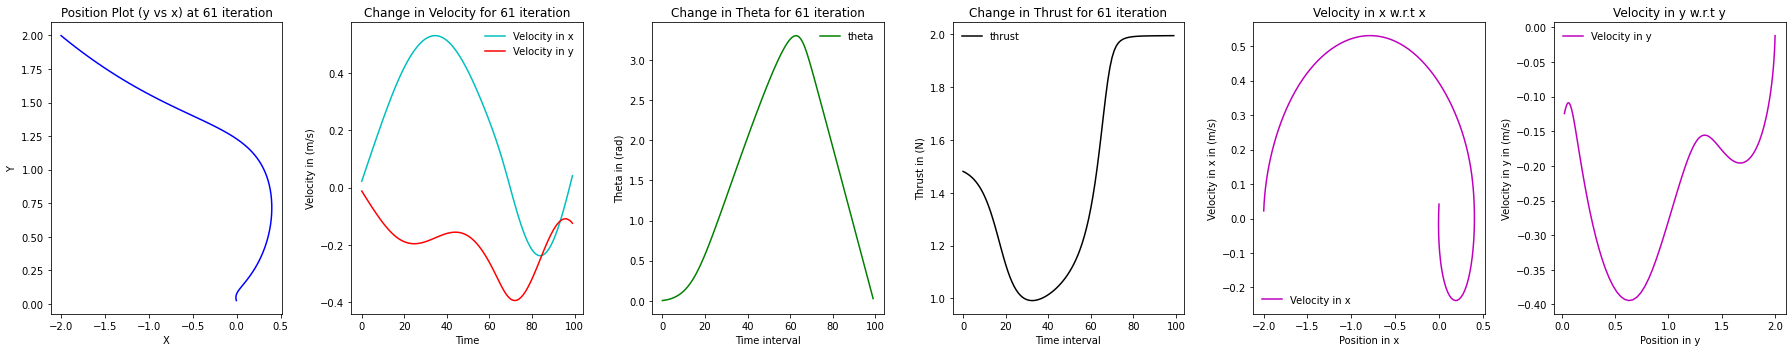

[62] loss: 0.004


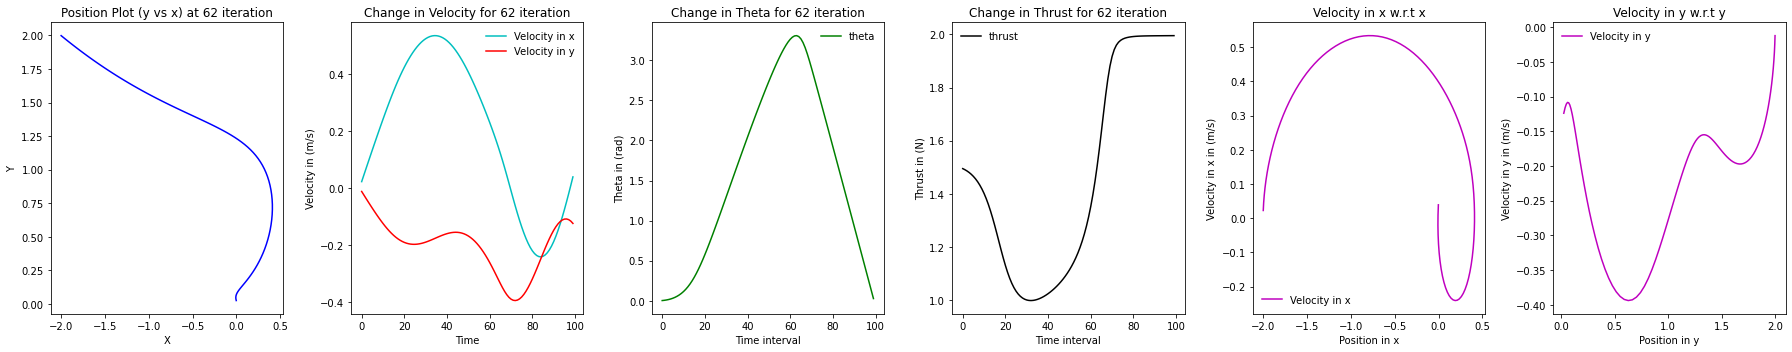

[63] loss: 0.004


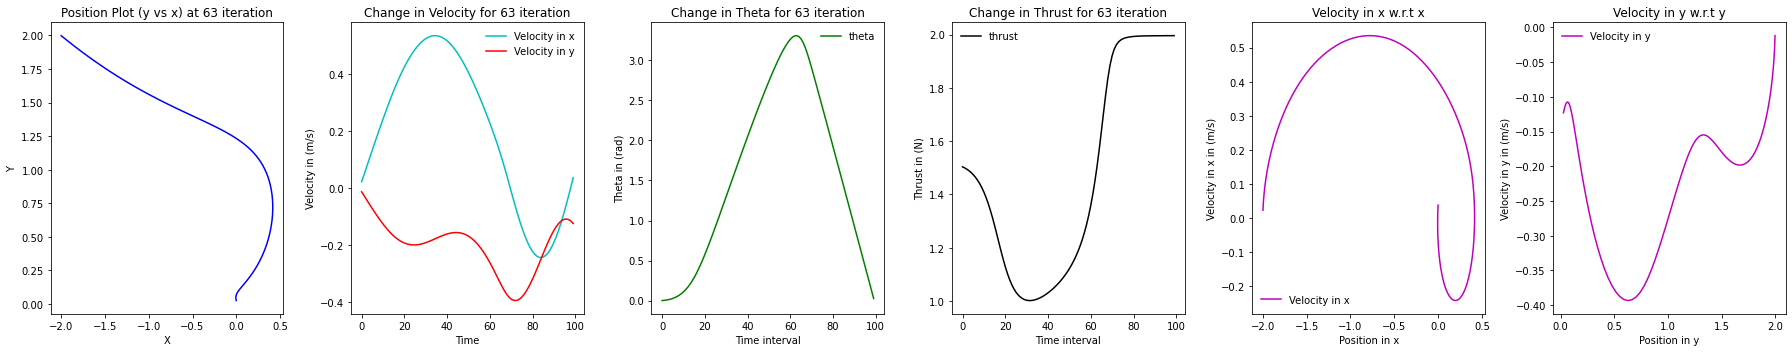

[64] loss: 0.004


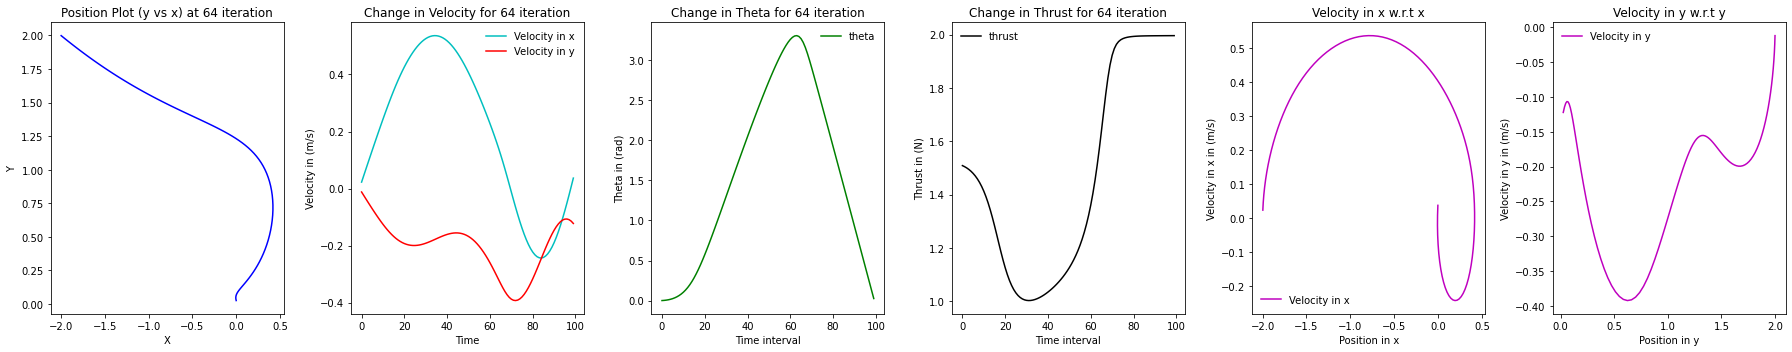

[65] loss: 0.003


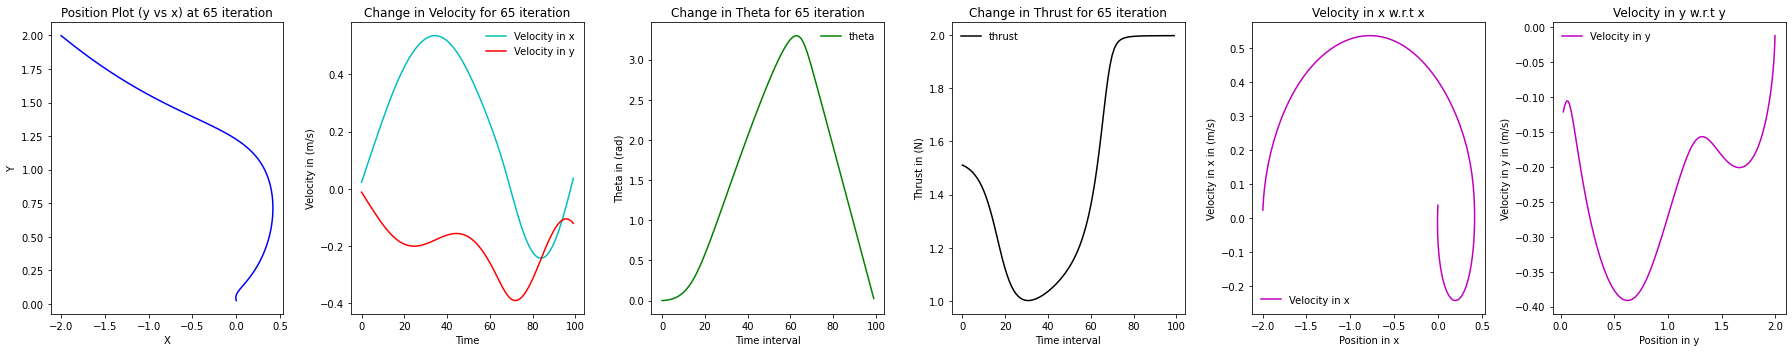

[66] loss: 0.003


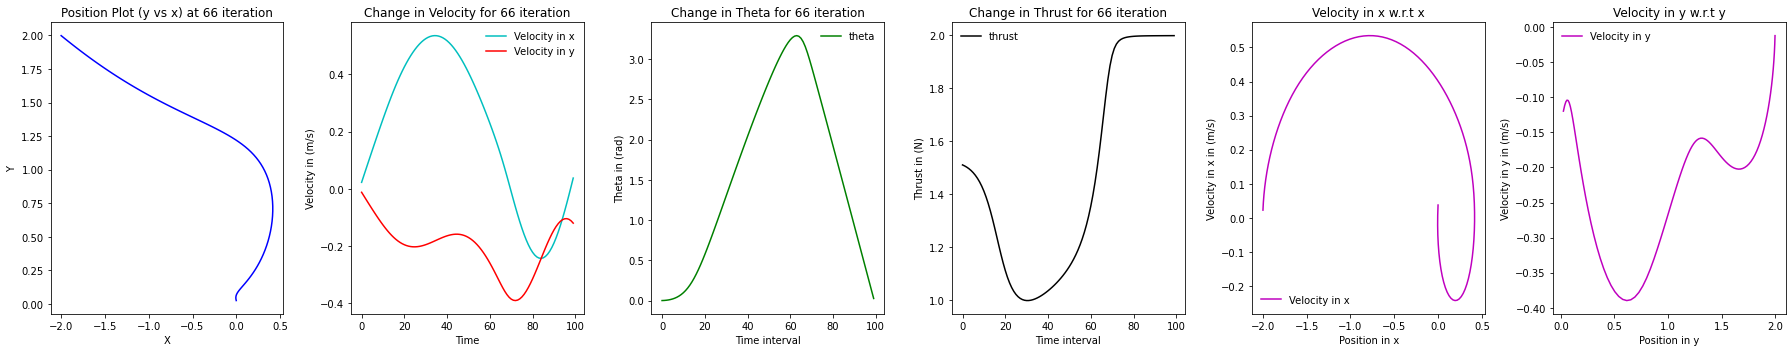

[67] loss: 0.003


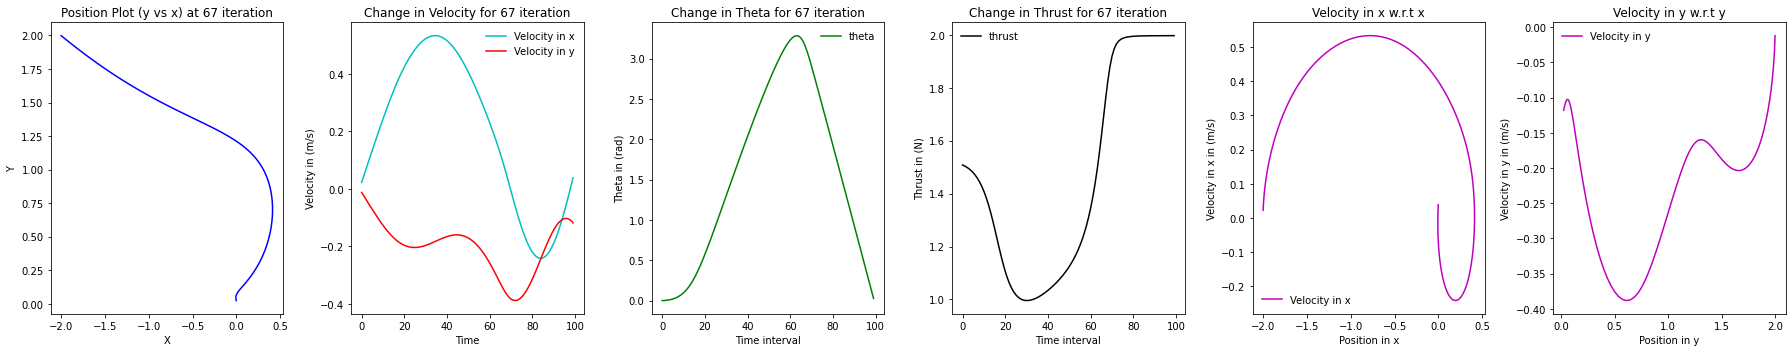

[68] loss: 0.023


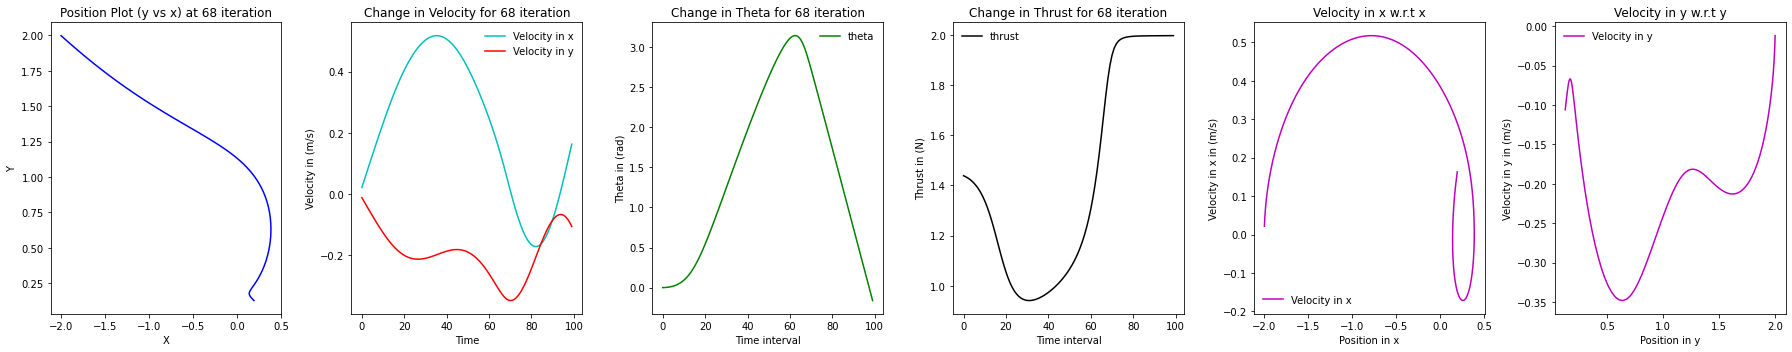

[69] loss: 0.015


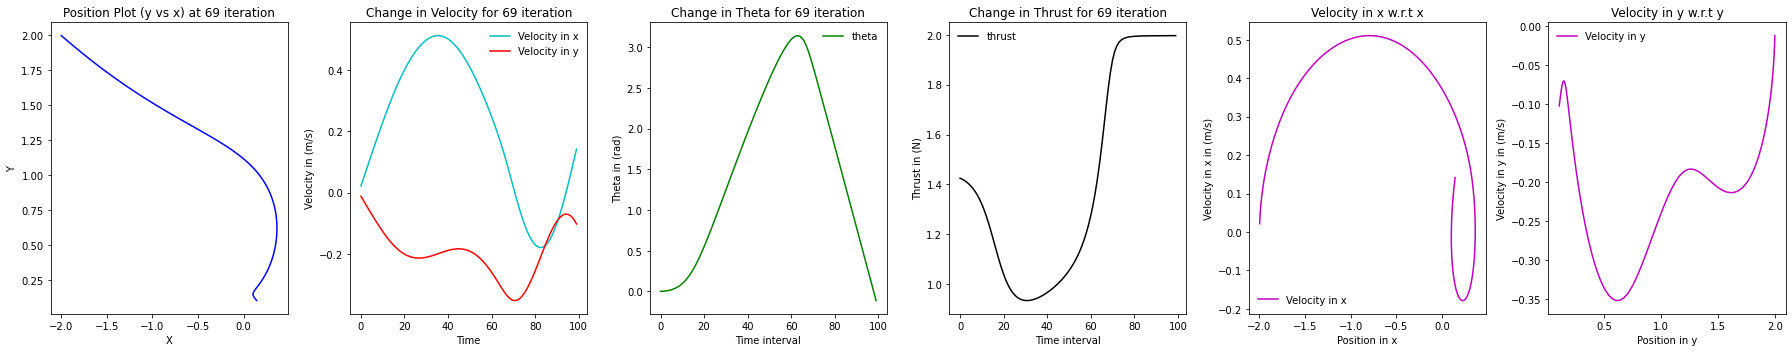

[70] loss: 0.021


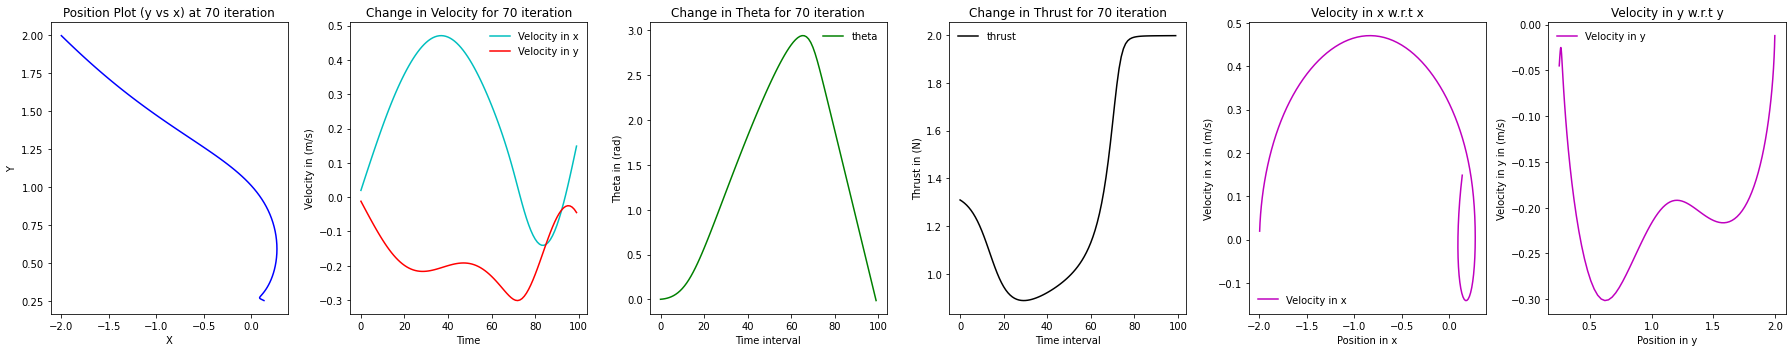

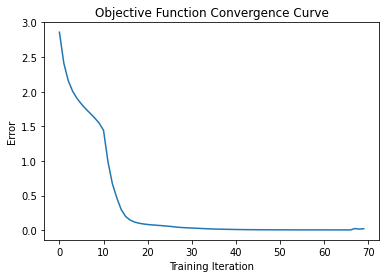

In [ ]:
T = 100  # number of time steps
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(70)  # training with number of epochs

<b><h1>Analysis of the Results</b></h1> <br>

As we can observe the graphs above, the loss decreases gradually and gets close to zero. However, we can observe that in the thrust vs time graph that the thrust slowly decreases and then gradually increases to then become constant over the final bit. After rigorous testing I found that the system gets too close to the landing point very quicky, but then it has slow down the thrust output otherwise the system will have to rise up again to then descent back to the landing point.

Maybe in future to imporve upon this model I can add several other constraints such as for accelaration and rotational velocity so that we can generate any magnitude force and we can also directly control the angular rotation of the rocket.
